In [109]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [104]:
# Installiere python packages falls noch nicht installiert
!pip install pandas numpy matplotlib scipy sqlalchemy tabulate scikit-learn seaborn ipywidgets

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/22/2d/9c0b76f2f9cc0ebede1b9371b6f317243028ed60b90705863d493bae622e/ipywidgets-8.1.5-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.12 from https://files.pythonhosted.org/packages/21/02/88b65cc394961a60c43c70517066b6b679738caf78506a5da7b88ffcb643/widgetsnbextension-4.0.13-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.12 from https://files.pythonhosted.org/packages/a9/93/858e87edc634d628e5d752ba944c2833133a28fa87bb093e6832ced36a3e/jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.2 MB/s eta 0:00:00:00:010:01m

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice]

In [2]:
#imports
import os
import sys
import platform
import zipfile
import pandas as pd 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import random


from collections import Counter
from sqlalchemy import func, Integer, case, distinct, and_,  cast, Float
from tabulate import tabulate  
from scipy.stats import chi2_contingency
from IPython.display import HTML, display, Markdown
from matplotlib import colormaps
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sqlalchemy import func

if not os.path.exists("./DABI1.db"):
    if platform.system() == "Windows":
        zip_folder = os.path.abspath(os.path.join(os.getcwd(), "../../Daten/"))
        
        for file_name in os.listdir(zip_folder):
            if file_name.endswith(".zip"):
                zip_path = os.path.join(zip_folder, file_name)
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(zip_folder) 
                print(f"Entpackt: {zip_path}")
        
        # dauert etwa 10 - 20 minuten
        os.system(f"python {os.path.abspath('../scripts/load_data_into_db.py')}")
    else:
        # UNIX/Linux/macOS-spezifischer Code
        os.system("sh ../scripts/unzip.sh")
        # dauert etwa 10 - 15 minuten
        os.system("python ../scripts/load_data_into_db.py")


notebook_dir = os.getcwd()  
module_path = os.path.abspath(os.path.join(notebook_dir, '..'))  
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.db import get_engine, get_session
from custom_types.db_models import Order, Product, Einkaufskorb, Department, Aisle

engine = get_engine(path = "sqlite:///DABI1.db")
session = get_session(engine)

abbildung = 1

Verbindung erfolgreich


# 📊 Datenanalyse des Instacarts-Datensatzes
### *für die Marketing- und Dispositionsabteilung*

---
<!-- text-align weil im normalen Jupyter lab die Tabelle zentriert wird -->
<h1 style="text-align: center;">👥 Projektteam</h1>

| Name | Matrikelnummer |
|------|----------------|
| Benjamin Saur | 71254|
| Uladzislau Dvornik | 80542 |
| Jan-David Wiederstein | 88219 |

---


## 📝 **Inhaltsverzeichnis**
1. [EDA Marketing](#marketing)
2. [EDA Disposition](#disposition)
3. [Konkrete Fragen](#fragen)
    1. [Frage 1](#frage1)
    2. [Frage 2](#frage2)
    3. [Frage 3](#frage3)
4. [Handlungsempfehlungen](#handlungsempfehlungen)

In [123]:
import time
import threading
from ipywidgets import Button, HTML, VBox, HBox
from IPython.display import display

class Stopwatch:
    def __init__(self):
        # Initialisiere Widgets
        self.time_label = HTML(
            value="<span style='font-size: 48px; color: white;'>00:00</span>",
            layout={'margin': '10px', 'padding': '10px'}
        )
        self.time_label.style = {"background": "transparent", "border": "none"}
        
        self.start_button = Button(description="Start")
        self.stop_button = Button(description="Stop", disabled=True)
        self.reset_button = Button(description="Reset", disabled=True)

        # Buttons in HBox horizontal anordnen
        self.button_box = HBox([self.start_button, self.stop_button, self.reset_button], 
                               layout={'justify_content': 'flex-start', 'gap': '10px' })

        # Buttons verbinden
        self.start_button.on_click(self.start)
        self.stop_button.on_click(self.stop)
        self.reset_button.on_click(self.reset)

        # Layout anzeigen
        display(VBox([self.time_label, self.button_box]))

        # Zeitvariablen
        self.running = False
        self.start_time = None
        self.elapsed_time = 0
        self.thread = None

    def start(self, b):
        if not self.running:
            self.running = True
            self.start_time = time.time() - self.elapsed_time  # Fortsetzen bei Pause
            self.start_button.disabled = True
            self.stop_button.disabled = False
            self.reset_button.disabled = False
            self.thread = threading.Thread(target=self.update_time)
            self.thread.start()

    def stop(self, b):
        if self.running:
            self.running = False
            self.elapsed_time = time.time() - self.start_time
            self.start_button.disabled = False
            self.stop_button.disabled = True

    def reset(self, b):
        self.running = False
        self.elapsed_time = 0
        self.time_label.value = "<span style='font-size: 48px; color: black;'>00:00</span>"
        self.start_button.disabled = False
        self.stop_button.disabled = True
        self.reset_button.disabled = True

    def update_time(self):
        while self.running:
            elapsed_time = time.time() - self.start_time
            minutes, seconds = divmod(elapsed_time, 60)
            self.time_label.value = f"<span style='font-size: 48px; color: white;'>{int(minutes):02d}:{int(seconds):02d}</span>"
            time.sleep(0.1)  # Aktualisiert alle 0.1 Sekunden

# Stoppuhr starten
stopwatch = Stopwatch()


---
# <h1 id="marketing">EDA Marketing</h1>

In [3]:
# Abfrage: Produkte mit ihrer Reihenfolge innerhalb einer Bestellung
result = session.query(
    Einkaufskorb.add_to_cart_order,
    Product.product_name,
    Einkaufskorb.order_id
).join(Product).order_by(Einkaufskorb.order_id, Einkaufskorb.add_to_cart_order).all()

df = pd.DataFrame(result, columns=["add_to_cart_order", "product_name","order_id"])

# Produkte, die häufig am Anfang (add_to_cart_order = 1) stehen
first_products = df[df['add_to_cart_order'] == 1]['product_name'].value_counts()


last_products_per_order = df.loc[df.groupby('order_id')['add_to_cart_order'].idxmax()]
last_product_counts = last_products_per_order['product_name'].value_counts()

print("Produkte am Anfang:")
print(first_products.head(10))  
print("\nProdukte am Ende:")
print(last_product_counts.head(10)) 

Produkte am Anfang:
product_name
Banana                    57776
Bag of Organic Bananas    41701
Organic Whole Milk        15981
Organic Strawberries      14552
Organic Hass Avocado      12658
Organic Baby Spinach      12142
Organic Avocado           11619
Spring Water               8914
Strawberries               8398
Organic Raspberries        7430
Name: count, dtype: int64

Produkte am Ende:
product_name
Banana                    15573
Bag of Organic Bananas    15497
Organic Strawberries      12199
Organic Baby Spinach      11311
Strawberries               8079
Organic Hass Avocado       7926
Organic Avocado            6319
Large Lemon                6165
Organic Blueberries        6023
Organic Whole Milk         5611
Name: count, dtype: int64


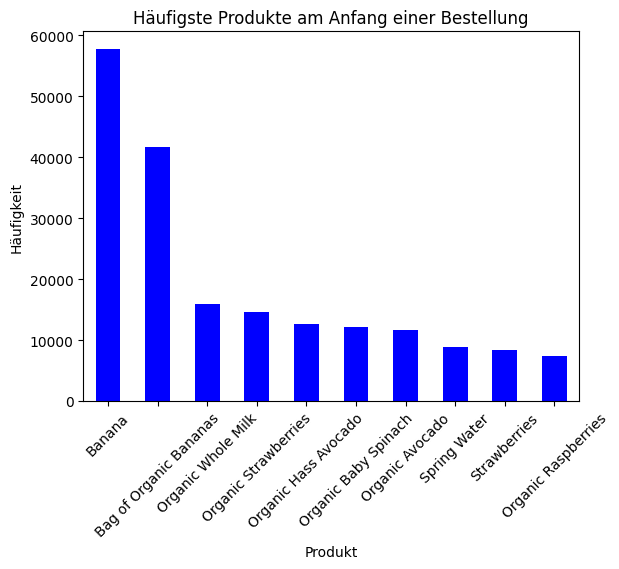

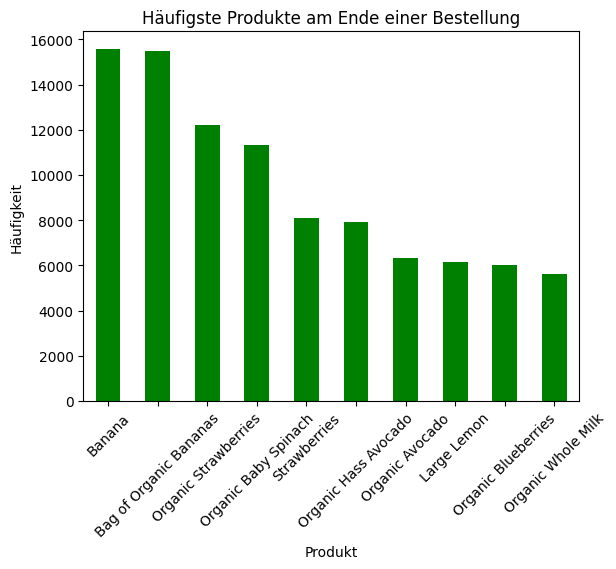

In [4]:
# Häufigste Produkte am Anfang
first_products.head(10).plot(kind='bar', title='Häufigste Produkte am Anfang einer Bestellung', color='blue')
plt.ylabel('Häufigkeit')
plt.xlabel('Produkt')
plt.xticks(rotation=45)
plt.show()

# Häufigste Produkte am Ende
last_product_counts.head(10).plot(kind='bar', title='Häufigste Produkte am Ende einer Bestellung', color='green')
plt.ylabel('Häufigkeit')
plt.xlabel('Produkt')
plt.xticks(rotation=45)
plt.show()

In [5]:
result = session.query(
    Einkaufskorb.order_id,
    Product.product_name
).join(Product).order_by(Einkaufskorb.order_id).limit(500000).all()

df = pd.DataFrame(result, columns=["order_id", "product_name"])

In [6]:
# Gruppiere Produkte nach Bestellung
order_groups = df.groupby("order_id")["product_name"].apply(list)

# Finde alle Paar-Kombinationen innerhalb jeder Bestellung
product_combinations = order_groups.apply(lambda products: list(itertools.combinations(products, 2)))

# Alle Kombinationen in eine flache Liste umwandeln
flat_combinations = [pair for pairs in product_combinations for pair in pairs]

# Häufigkeit jeder Kombination zählen
combination_counts = Counter(flat_combinations)

# Die Top-10-Kombinationen anzeigen
top_combinations = combination_counts.most_common(10)
print("Top 10 Produktkombinationen:")
for combo, count in top_combinations:
    print(f"{combo}: {count}")

Top 10 Produktkombinationen:
('Bag of Organic Bananas', 'Organic Hass Avocado'): 966
('Bag of Organic Bananas', 'Organic Strawberries'): 950
('Organic Strawberries', 'Banana'): 900
('Bag of Organic Bananas', 'Organic Baby Spinach'): 804
('Banana', 'Organic Avocado'): 803
('Organic Baby Spinach', 'Banana'): 792
('Bag of Organic Bananas', 'Organic Raspberries'): 655
('Banana', 'Large Lemon'): 651
('Strawberries', 'Banana'): 622
('Organic Strawberries', 'Organic Baby Spinach'): 600


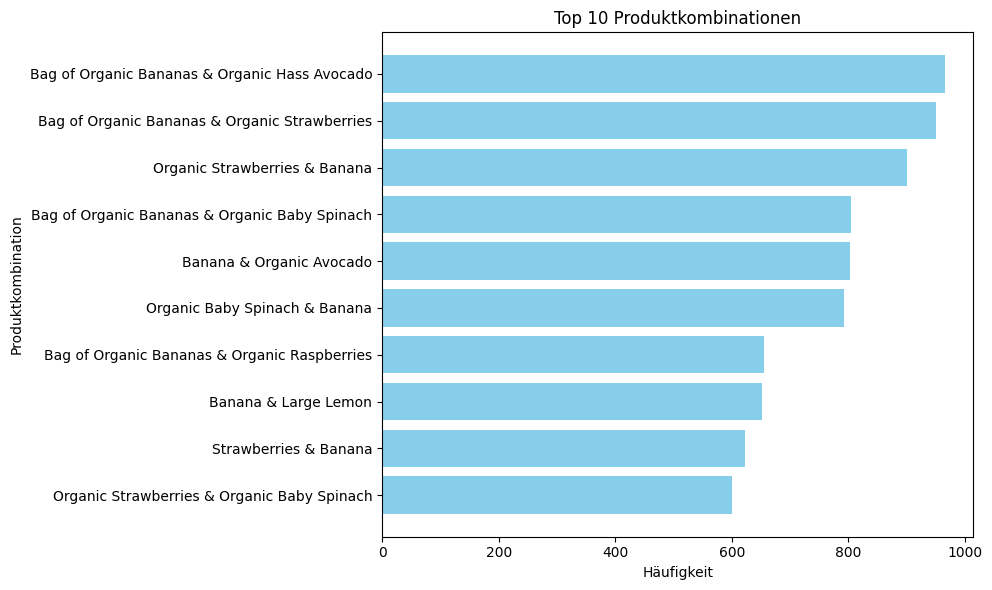

In [7]:
combos, counts = zip(*top_combinations)

plt.figure(figsize=(10, 6))
plt.barh([f"{combo[0]} & {combo[1]}" for combo in combos], counts, color='skyblue')
plt.title("Top 10 Produktkombinationen")
plt.xlabel("Häufigkeit")
plt.ylabel("Produktkombination")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
result = session.query(
    Einkaufskorb.order_id,
    Department.department_name
).join(Product, Einkaufskorb.product_id == Product.product_id) \
 .join(Department, Product.department_id == Department.department_id) \
 .distinct()  # Entfernt Duplikate innerhalb derselben Bestellung

f = pd.DataFrame(result, columns=["order_id", "department"])

In [9]:
grouped = f.groupby('order_id')['department'].apply(set)

# Schritt 2: Generiere paarweise Kombinationen von Departments
department_pairs = grouped.apply(lambda x: list(itertools.combinations(x, 2)))

# Schritt 3: Flache Liste aller Paare erstellen
flat_pairs = [pair for pairs in department_pairs for pair in pairs]

# Schritt 4: Häufigkeit der Co-Käufe zählen
pair_counts = Counter(flat_pairs)

# Schritt 5: Ergebnisse als DataFrame darstellen
pair_counts_df = pd.DataFrame(pair_counts.items(), columns=['department_pair', 'count']).sort_values(by='count', ascending=False)

# Ergebnisse anzeigen
print(pair_counts_df.head(10))

             department_pair   count
0      (produce, dairy eggs)  919741
16         (produce, snacks)  561945
20      (produce, beverages)  558611
56   (dairy eggs, beverages)  533276
3          (produce, pantry)  479518
4       (pantry, dairy eggs)  452850
35      (snacks, dairy eggs)  450901
79         (produce, frozen)  411896
128        (produce, bakery)  379248
111     (dairy eggs, frozen)  345061


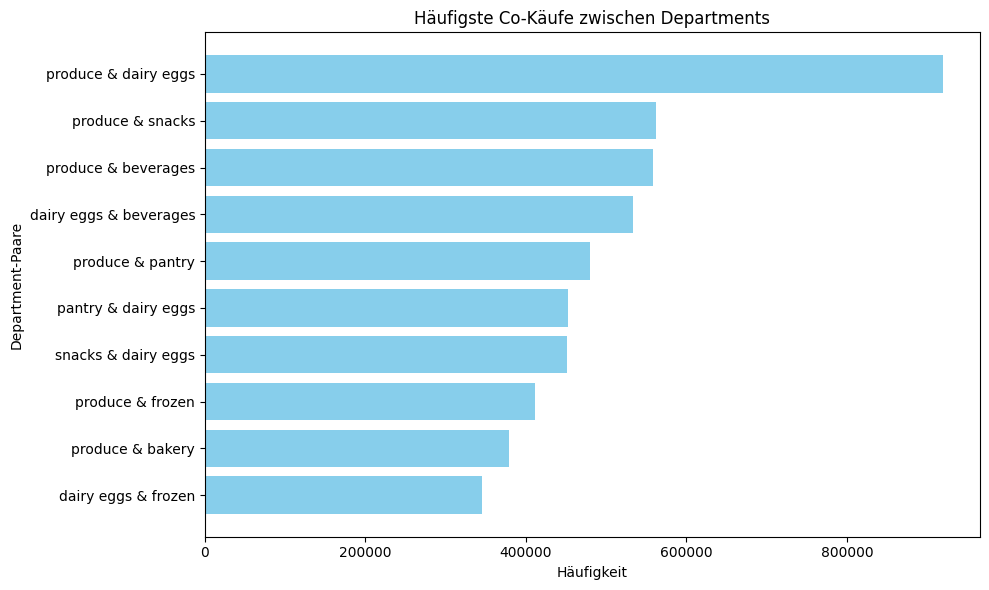

In [10]:
top_pairs = pair_counts_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh([f"{pair[0]} & {pair[1]}" for pair in top_pairs['department_pair']], top_pairs['count'], color='skyblue')
plt.xlabel('Häufigkeit')
plt.ylabel('Department-Paare')
plt.title('Häufigste Co-Käufe zwischen Departments')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
result = session.query(
    Order.user_id,
    Einkaufskorb.order_id,
    Einkaufskorb.product_id,
    Product.product_name
).join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id) \
 .join(Product, Einkaufskorb.product_id == Product.product_id) \
 .distinct().limit(100000)


df = pd.DataFrame(result, columns=["user_id", "order_id", "product_id", "product_name"])



In [12]:
# Gesamtzahl der Bio-Produkte
total_bio_products = session.query(func.count(func.distinct(Product.product_id))) \
    .filter(Product.product_name.ilike('%organic%')) \
    .scalar()

# Gesamtzahl der Produkte im Sortiment
total_products = session.query(func.count(func.distinct(Product.product_id))).scalar()

# Berechnung des Anteils der Bio-Produkte an allen Produkten
bio_percentage = total_bio_products / total_products if total_products > 0 else 0


bio_percentage

0.1013524392207374

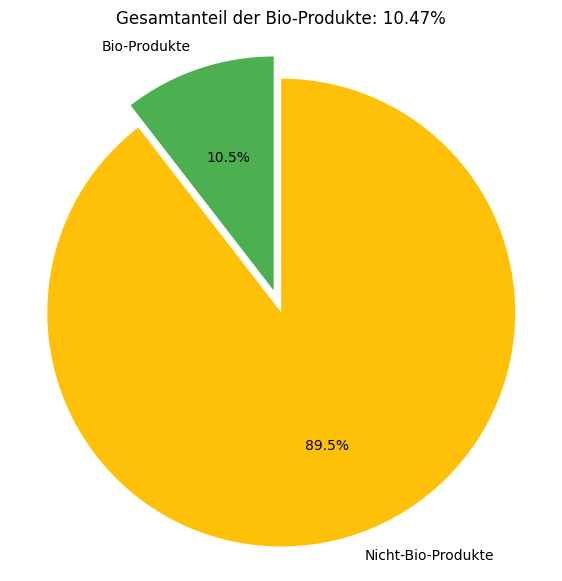

In [94]:
labels = 'Bio-Produkte', 'Nicht-Bio-Produkte'
sizes = [bio_percentage, 1 - bio_percentage]
colors = ['#4CAF50', '#FFC107']  # Grün für Bio-Produkte, Rot für Nicht-Bio-Produkte

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.1, 0))
# plt.title(f'Gesamtanteil der Bio-Produkte: {gesamt_bio_anteil*100:.2f}%')
plt.title(f'Gesamtanteil der Bio-Produkte: {bio_percentage*100:.2f}%')
plt.axis('equal')  # Kreis wird als Kreis angezeigt
plt.show()

In [100]:
# Query: Anzahl der Bestellungen mit Bio-Produkten vs. Gesamtanzahl der Bestellungen
orders_with_organic = (
    session.query(Order.order_id)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)  
    .join(Product, Einkaufskorb.product_id == Product.product_id) 
    .filter(Product.product_name.ilike('%organic%'))  
    .distinct()  
    .group_by(Order.order_id)  
    .count()  
)

total_orders = session.query(Order).count()


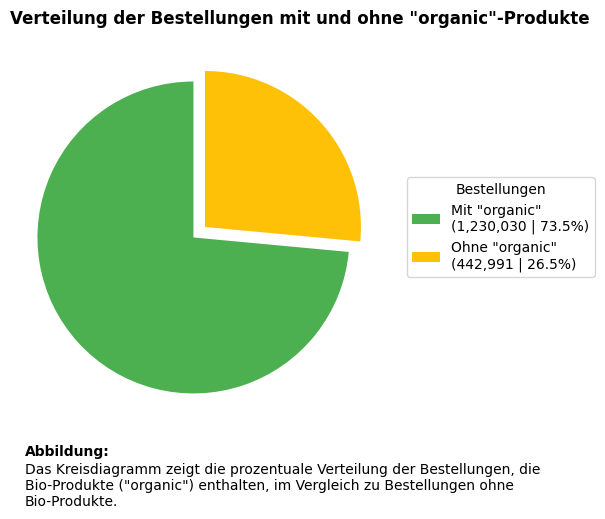

In [101]:
orders_without_organic = total_orders - orders_with_organic

labels = ['Mit "organic"', 'Ohne "organic"']
sizes = [orders_with_organic, orders_without_organic]
colors = ['#4CAF50', '#FFC107']  
explode = (0.1, 0)  

fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(left=0.08)

# Berechne die Prozentanteile
percentages = [s/total_orders*100 for s in sizes]
# Erstelle Labels mit absoluten Zahlen und Prozenten
labels_with_values = [f'{labels[i]}\n({sizes[i]:,} | {percentages[i]:.1f}%)' 
                     for i in range(len(labels))]

wedges, texts = ax.pie(sizes, labels=None, colors=colors, explode=explode, startangle=90)

ax.legend(wedges, labels_with_values,
         title="Bestellungen",
         loc="center left",
         bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('Verteilung der Bestellungen mit und ohne "organic"-Produkte', 
             loc='left', weight='bold')

description = 'Das Kreisdiagramm zeigt die prozentuale Verteilung der Bestellungen, die Bio-Produkte ("organic") enthalten, im Vergleich zu Bestellungen ohne Bio-Produkte.'
fig.text(0.05, 0.1, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, 0.02, description, wrap=True)

plt.tight_layout()
plt.show()

In [16]:
# Abfrage für die Verteilung der Bio-Produkte
organic_distribution = (
    session.query(
        Order.order_id,
        (func.count(case((Product.product_name.ilike('%organic%'), 1))) * 100.0 / 
         func.count(Product.product_id)).label('organic_percentage')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .group_by(Order.order_id)
    .subquery()
)

# Gruppierung der Ergebnisse
groups = {
    '0%': 0,
    '1-25%': 0,
    '26-50%': 0,
    '51-75%': 0,
    '76-99%': 0,
    '100%': 0
}

results = session.query(
    case(
        
            (organic_distribution.c.organic_percentage == 0, '0%'),
            (organic_distribution.c.organic_percentage <= 25, '1-25%'),
            (organic_distribution.c.organic_percentage <= 50, '26-50%'),
            (organic_distribution.c.organic_percentage <= 75, '51-75%'),
            (organic_distribution.c.organic_percentage < 100, '76-99%'),
            (organic_distribution.c.organic_percentage == 100, '100%')
        
    ).label('group'),
    func.count('*').label('count')
).group_by('group').all()

# Ergebnisse in Dictionary speichern
for group, count in results:
    if group in groups:
        groups[group] = count

# Gesamtanzahl der Bestellungen
total_orders = sum(groups.values())

# Ausgabe der Ergebnisse
print("Verteilung der Bio-Produkte in Bestellungen:")
for group, count in groups.items():
    percentage = (count / total_orders) * 100 if total_orders > 0 else 0
    print(f"{group}: {count} Bestellungen ({percentage:.2f}%)")

Verteilung der Bio-Produkte in Bestellungen:
0%: 442991 Bestellungen (26.48%)
1-25%: 375675 Bestellungen (22.45%)
26-50%: 539189 Bestellungen (32.23%)
51-75%: 237870 Bestellungen (14.22%)
76-99%: 36717 Bestellungen (2.19%)
100%: 40579 Bestellungen (2.43%)


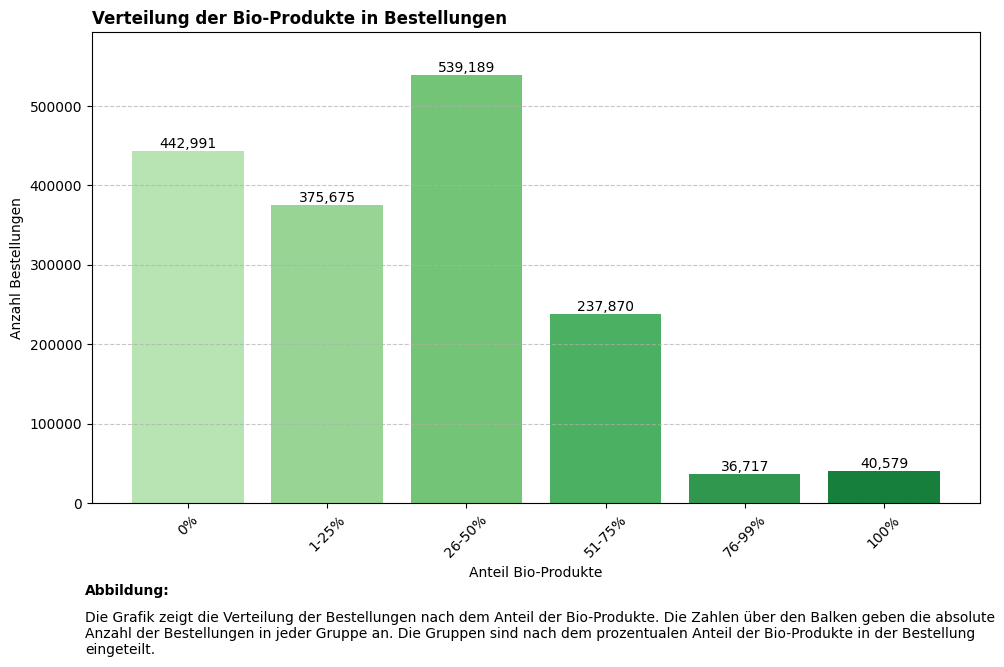

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
group_names = list(groups.keys())
group_values = list(groups.values())

# Farbpalette erstellen (Farbverlauf von hellgrün zu dunkelgrün)
colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(group_names)))

# Balkendiagramm erstellen
bars = ax.bar(group_names, group_values, color=colors)

# Achsentitel und Formatierung
ax.set_ylabel('Anzahl Bestellungen')
ax.set_xlabel('Anteil Bio-Produkte')
ax.set_title('Verteilung der Bio-Produkte in Bestellungen', 
             loc='left', weight='bold')
ax.set_xticks(range(len(group_names)))
ax.set_xticklabels(group_names, rotation=45)

# Grid hinzufügen
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Y-Achse formatieren
max_value = max(group_values)
ax.set_ylim(0, max_value * 1.1)  # 10% Platz für Labels

# Werte über den Balken anzeigen
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f"{int(height):,}", ha='center', va='bottom', fontsize=10)

# Bildunterschrift
description = ('Die Grafik zeigt die Verteilung der Bestellungen nach dem Anteil der Bio-Produkte. '
              'Die Zahlen über den Balken geben die absolute Anzahl der Bestellungen in jeder Gruppe an. '
              'Die Gruppen sind nach dem prozentualen Anteil der Bio-Produkte in der Bestellung eingeteilt.')

fig.text(0.09, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.09, -0.095, description, wrap=True)

plt.tight_layout()
plt.show()

In [18]:
# Berechnung der Anzahl der Produkte pro Department
department_product_count = session.query(
    Department.department_name,
    func.count(func.distinct(Product.product_id)).label('product_count')
) \
    .join(Product, Product.department_id == Department.department_id) \
    .group_by(Department.department_name) \
    .all()

# Ausgabe der Ergebnisse
for department in department_product_count:
    print(f"Department: {department.department_name}, Number of Products: {department.product_count}")


Department: alcohol, Number of Products: 1054
Department: babies, Number of Products: 1081
Department: bakery, Number of Products: 1516
Department: beverages, Number of Products: 4365
Department: breakfast, Number of Products: 1115
Department: bulk, Number of Products: 38
Department: canned goods, Number of Products: 2092
Department: dairy eggs, Number of Products: 3449
Department: deli, Number of Products: 1322
Department: dry goods pasta, Number of Products: 1858
Department: frozen, Number of Products: 4007
Department: household, Number of Products: 3085
Department: international, Number of Products: 1139
Department: meat seafood, Number of Products: 907
Department: missing, Number of Products: 1258
Department: other, Number of Products: 548
Department: pantry, Number of Products: 5371
Department: personal care, Number of Products: 6563
Department: pets, Number of Products: 972
Department: produce, Number of Products: 1684
Department: snacks, Number of Products: 6264


In [19]:
# Berechnung der Anzahl der Bio-Produkte pro Department
department_bio_product_count = session.query(
    Department.department_name,
    func.count(func.distinct(Product.product_id)).label('bio_product_count')
) \
    .join(Product, Product.department_id == Department.department_id) \
    .filter(Product.product_name.ilike('%organic%')) \
    .group_by(Department.department_name) \
    .all()

# Ausgabe der Ergebnisse
for department in department_bio_product_count:
    print(f"Department: {department.department_name}, Bio Products: {department.bio_product_count}")


Department: alcohol, Bio Products: 15
Department: babies, Bio Products: 260
Department: bakery, Bio Products: 116
Department: beverages, Bio Products: 624
Department: breakfast, Bio Products: 155
Department: bulk, Bio Products: 22
Department: canned goods, Bio Products: 320
Department: dairy eggs, Bio Products: 435
Department: deli, Bio Products: 100
Department: dry goods pasta, Bio Products: 300
Department: frozen, Bio Products: 252
Department: household, Bio Products: 9
Department: international, Bio Products: 84
Department: meat seafood, Bio Products: 47
Department: missing, Bio Products: 175
Department: other, Bio Products: 37
Department: pantry, Bio Products: 746
Department: personal care, Bio Products: 187
Department: pets, Bio Products: 23
Department: produce, Bio Products: 473
Department: snacks, Bio Products: 656


In [20]:
# Berechnung des Anteils der Bio-Produkte pro Department
department_bio_percentage = []

# Gehe durch jedes Department und berechne den Anteil
for dept in department_bio_product_count:
    for dept_total in department_product_count:
        if dept.department_name == dept_total.department_name:
            bio_percentage = dept.bio_product_count / dept_total.product_count if dept_total.product_count > 0 else 0
            department_bio_percentage.append({
                "department_name": dept.department_name,
                "bio_products_count": dept.bio_product_count,
                "total_products_count": dept_total.product_count,
                "bio_percentage": bio_percentage
            })

# Ausgabe der Ergebnisse
for result in department_bio_percentage:
    print(f"Department: {result['department_name']}, Bio Products: {result['bio_products_count']}, "
          f"Total Products: {result['total_products_count']}, Bio Products Percentage: {result['bio_percentage']*100:.2f}%")

Department: alcohol, Bio Products: 15, Total Products: 1054, Bio Products Percentage: 1.42%
Department: babies, Bio Products: 260, Total Products: 1081, Bio Products Percentage: 24.05%
Department: bakery, Bio Products: 116, Total Products: 1516, Bio Products Percentage: 7.65%
Department: beverages, Bio Products: 624, Total Products: 4365, Bio Products Percentage: 14.30%
Department: breakfast, Bio Products: 155, Total Products: 1115, Bio Products Percentage: 13.90%
Department: bulk, Bio Products: 22, Total Products: 38, Bio Products Percentage: 57.89%
Department: canned goods, Bio Products: 320, Total Products: 2092, Bio Products Percentage: 15.30%
Department: dairy eggs, Bio Products: 435, Total Products: 3449, Bio Products Percentage: 12.61%
Department: deli, Bio Products: 100, Total Products: 1322, Bio Products Percentage: 7.56%
Department: dry goods pasta, Bio Products: 300, Total Products: 1858, Bio Products Percentage: 16.15%
Department: frozen, Bio Products: 252, Total Products: 

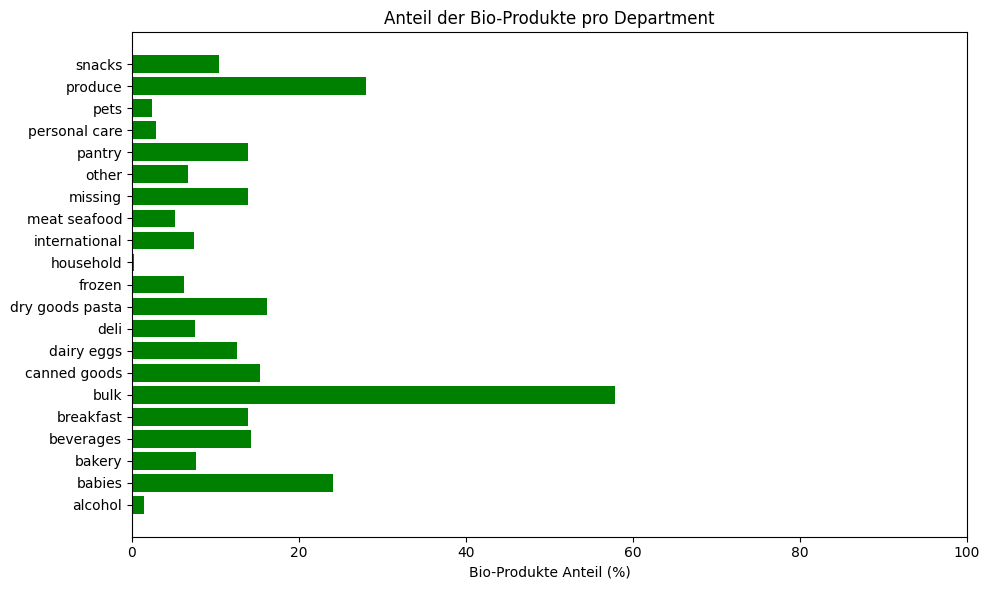

In [21]:
gesamt_bio_produkte = sum([result['bio_products_count'] for result in department_bio_percentage])
gesamt_produkte = sum([result['total_products_count'] for result in department_bio_percentage])

gesamt_bio_anteil = gesamt_bio_produkte / gesamt_produkte if gesamt_produkte > 0 else 0

# Umwandlung der Anteile in Prozentsätze
bio_anteile_prozent = [result['bio_percentage'] * 100 for result in department_bio_percentage]

# Visualisierung des Anteils der Bio-Produkte pro Department (Balkendiagramm)
departments = [result['department_name'] for result in department_bio_percentage]

plt.figure(figsize=(10, 6))
plt.barh(departments, bio_anteile_prozent, color='green')

# Setze die X-Achse auf den Bereich von 0 bis 100% (0 bis 100)
plt.xlim(0, 100)

plt.xlabel('Bio-Produkte Anteil (%)')
plt.title('Anteil der Bio-Produkte pro Department')

plt.tight_layout()
plt.show()




<div style="margin-top: 15px;">
        <strong>💡 Schlussfolgerungen:</strong>
        <p>Obwohl Bio-Produkte nur 10% des gesamten Produktsortiments ausmachen, sind sie in 73,5% der Bestellungen mindestens einmal vertreten. Dies zeigt, dass Bio-Produkte eine hohe Nachfrage haben, obwohl sie in der Produktvielfalt relativ gering vertreten sind. Dies könnte darauf hindeuten, dass Kunden, die sich für Bio-Produkte entscheiden, diese häufiger in ihren Bestellungen einbeziehen. Ein höherer Anteil von Bio-Produkten könnte daher potenziell das Einkaufserlebnis und die Zufriedenheit der Kunden steigern.</p>
    </div>




Für die Marketing Abteilung wurde ein Empfehlungsdienst für die Nutzer implementiert

In [22]:
# Schritt 1: Alle Benutzer-IDs erfassen
all_users = session.query(Order.user_id).distinct().all()

# Benutzer-IDs extrahieren
all_user_ids = [user.user_id for user in all_users]

# Schritt 2: 10 % der Benutzer zufällig auswählen
sampled_user_ids = random.sample(all_user_ids, int(len(all_user_ids) * 0.01))

# Schritt 3: Abfrage für Bestellungen dieser Benutzer
result = session.query(
    Order.user_id,
    Einkaufskorb.order_id,
    Einkaufskorb.product_id,
    Product.product_name
).join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id) \
 .join(Product, Einkaufskorb.product_id == Product.product_id) \
 .filter(Order.user_id.in_(sampled_user_ids)) \
 .distinct()

df = pd.DataFrame(result, columns=["user_id", "order_id", "product_id", "product_name"])

print(df.head())


   user_id  order_id  product_id            product_name
0   102031       319        2515        Evaporated Milk,
1   102031       319        5337    Monterey Jack Cheese
2   102031       319        9387     Granny Smith Apples
3   102031       319       13176  Bag of Organic Bananas
4   102031       319       17207    Non Fat Greek Yogurt


In [23]:
user_product_matrix = df.pivot_table(index='user_id', columns='product_id', aggfunc='size', fill_value=0)

# Schritt 2: Cosine Similarity berechnen
user_similarity = cosine_similarity(user_product_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_product_matrix.index, columns=user_product_matrix.index)

# Schritt 3: Empfehlungen generieren
def recommend_products(user_id, n_recommendations=5):
    # Ähnlichkeit des Nutzers zu anderen Nutzern
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:]
    
    # Produkte des angegebenen Nutzers
    user_products = set(user_product_matrix.columns[user_product_matrix.loc[user_id] > 0])
    
    # Empfehlungen sammeln
    recommendations = {}
    for similar_user in similar_users:
        similar_user_products = set(user_product_matrix.columns[user_product_matrix.loc[similar_user] > 0])
        new_products = similar_user_products - user_products
        for product in new_products:
            if product not in recommendations:
                recommendations[product] = 0
            recommendations[product] += user_similarity_df.loc[user_id, similar_user]
    
    # Sortiere Empfehlungen nach Gewichtung
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    # Gib die Top N Produkt-IDs zurück
    return [product for product, score in sorted_recommendations[:n_recommendations]]



In [24]:
recommendations = recommend_products(sampled_user_ids[1], n_recommendations=10)
recommended_products = df[df["product_id"].isin(recommendations)]
recommended_product_names = recommended_products["product_name"].unique()

In [25]:
print(f"Empfohlene Produkte für Nutzer {sampled_user_ids[1]}:")
for name in recommended_product_names:
    print(name)

Empfohlene Produkte für Nutzer 192536:
Bag of Organic Bananas
Organic Baby Spinach
Organic Garlic
Organic Avocado
Large Lemon
Organic Blueberries
Cucumber Kirby
Blueberries
Limes
Organic Zucchini


---
# <h1 id="disposition">EDA Disposition</h1>

## 📊 1. Allgemeine Analyse des Trinkgeldverhaltens

<div style="padding: 15px; border-radius: 5px; border-left: 5px solid #3498db; margin: 10px 0;">
    <strong>🎯 Zielsetzung:</strong>
    <p style="margin: 10px 0 0 0;">
        Untersuchung der generellen Verteilung der Trinkgeldvergabe über alle Bestellungen hinweg.
    </p>
</div>

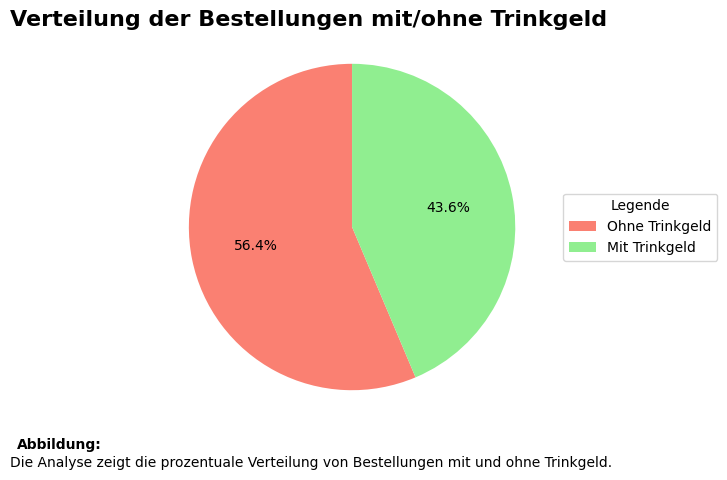

|    | tips   |   count |   percentage |
|---:|:-------|--------:|-------------:|
|  0 | False  |  942908 |      56.3596 |
|  1 | True   |  730113 |      43.6404 |

In [26]:
tip_counts = (
    session.query(
        Order.tips,               
        func.count(Order.order_id)  
    )
    .group_by(Order.tips)
    .all()
)

tip_counts_df = pd.DataFrame(tip_counts, columns=['tips', 'count'])
total_orders = tip_counts_df['count'].sum()
tip_counts_df['percentage'] = (tip_counts_df['count'] / total_orders) * 100
table_markdown = tabulate(tip_counts_df, headers='keys', tablefmt='pipe')

plt.figure(figsize=(6, 6))

labels = ['Ohne Trinkgeld', 'Mit Trinkgeld']
colors = ['salmon', 'lightgreen']
patches, texts, autotexts = plt.pie(tip_counts_df['count'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)

plt.legend(patches, labels, title="Legende", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


fig = plt.gcf()  
fig.text(0.415, 0.875, 'Verteilung der Bestellungen mit/ohne Trinkgeld', 
         fontweight='bold', fontsize=16, ha='center')
description = 'Die Analyse zeigt die prozentuale Verteilung von Bestellungen mit und ohne Trinkgeld.'
fig.text(0, 0.17, f'Abbildung:', fontweight='bold', ha='center')
fig.text(0.42, 0.14, description, ha='center')

plt.subplots_adjust(bottom=0.2, right=0.85)  

plt.show()
display(Markdown(f"{table_markdown}"))

In [27]:
# Query: Anzahl der Produkte pro Bestellung und ob Trinkgeld gegeben wurde
all_orders_item_count_with_tips = session.query(
    Order.order_id,
    func.count(Einkaufskorb.product_id).label('item_count'),
    Order.tips,
    func.count(Order.order_id).label('total_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .group_by(Order.order_id) \
 .all()

### Analyse des Trinkgeldverhaltens des Kunden

In [29]:
# Benutzerstatistiken: Gesamtbestellungen, Bestellungen mit Trinkgeld und durchschnittliche Bestellgröße pro Benutzer
user_stats = (
    session.query(
        Order.user_id,
        func.count(Order.order_id).label('total_orders'), 
        func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')  
    )
    .group_by(Order.user_id)
    .order_by(Order.user_id)
    .all()
)

avg_order_size_subquery = (
    session.query(
        Order.user_id,
        func.count(Einkaufskorb.product_id).label('order_size')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .group_by(Order.order_id)
).subquery()

avg_order_size = (
    session.query(
        avg_order_size_subquery.c.user_id,
        func.avg(avg_order_size_subquery.c.order_size).label('avg_order_size')
    )
    .group_by(avg_order_size_subquery.c.user_id)
    .order_by(avg_order_size_subquery.c.user_id)
    .all()
)

avg_order_size_df = pd.DataFrame(avg_order_size, columns=['user_id', 'avg_order_size'])

user_stats_df = pd.DataFrame(user_stats, columns=['user_id', 'total_orders', 'orders_with_tips'])

user_stats_df['orders_without_tips'] = user_stats_df['total_orders'] - user_stats_df['orders_with_tips']

user_stats_df = user_stats_df.merge(avg_order_size_df, on='user_id')

user_stats_df['order_group'] = pd.cut(user_stats_df['total_orders'], bins=range(1, 102, 10), right=False)
user_stats_df['item_count_group'] = pd.cut(user_stats_df['avg_order_size'], bins=range(1, 32, 3), right=False)

grouped_stats_df_item_count = user_stats_df.groupby('item_count_group', observed=True).agg(
    orders_with_tips=('orders_with_tips', 'sum'),
    orders_without_tips=('orders_without_tips', 'sum'),
    total_orders=('total_orders', 'sum')
).reset_index()

grouped_stats_df = user_stats_df.groupby('order_group', observed=True).agg(
    orders_with_tips=('orders_with_tips', 'sum'),
    orders_without_tips=('orders_without_tips', 'sum'),
    total_orders=('total_orders', 'sum')
).reset_index()

grouped_stats_df['tips_ratio'] = grouped_stats_df['orders_with_tips'] / grouped_stats_df['total_orders']
grouped_stats_df_item_count['tips_ratio'] = grouped_stats_df_item_count['orders_with_tips'] / grouped_stats_df_item_count['total_orders']
# 


In [30]:
grouped_stats_df

,order_group,orders_with_tips,orders_without_tips,total_orders,tips_ratio
0,"[1, 11)",89983,236698,326681,0.275446
1,"[11, 21)",133246,226480,359726,0.370410
2,"[21, 31)",122669,141444,264113,0.464457
3,"[31, 41)",103809,88585,192394,0.539565
4,"[41, 51)",91546,67904,159450,0.574136
5,"[51, 61)",64700,49222,113922,0.567932
6,"[61, 71)",39767,34737,74504,0.533757
7,"[71, 81)",25089,25303,50392,0.497877
8,"[81, 91)",19023,19412,38435,0.494940
9,"[91, 101)",40281,53123,93404,0.431256


In [31]:
grouped_stats_df_item_count

,item_count_group,orders_with_tips,orders_without_tips,total_orders,tips_ratio
0,"[1, 4)",65194,110654,175848,0.370741
1,"[4, 7)",154210,199935,354145,0.435443
2,"[7, 10)",185093,226977,412070,0.449179
3,"[10, 13)",141483,170454,311937,0.453563
4,"[13, 16)",84475,103825,188300,0.448619
5,"[16, 19)",47323,59990,107313,0.440981
6,"[19, 22)",26517,33158,59675,0.444357
7,"[22, 25)",12662,18285,30947,0.409151
8,"[25, 28)",6394,9226,15620,0.409347
9,"[28, 31)",3439,5451,8890,0.386839


### 📊 Analyse des Kundentrinkgeldverhaltens in Abhängigkeit der Bestellhäufigkeit

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Untersuchungsfokus</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        In dieser Analyse untersuchen wir den Zusammenhang zwischen der Bestellhäufigkeit eines Kunden und 
        seinem Trinkgeldverhalten. Dabei betrachten wir sowohl die absolute Verteilung als auch die relative 
        Entwicklung der Trinkgeldquote.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungsaufbau:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Gestapeltes Balkendiagramm zur Darstellung der absoluten Häufigkeiten</li>
            <li><strong>Rechter Plot:</strong> Verlauf der Trinkgeldquote über die Bestellhäufigkeit</li>
            <li>Gruppierung der Kunden nach Anzahl ihrer Bestellungen in Intervallen</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziele:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Identifikation von Mustern im Trinkgeldverhalten von Stammkunden</li>
            <li>Untersuchung der Kundenverteilung nach Bestellhäufigkeit</li>
            <li>Analyse der Entwicklung der Trinkgeldquote bei steigender Bestellanzahl</li>
        </ul>
    </div>
</div>

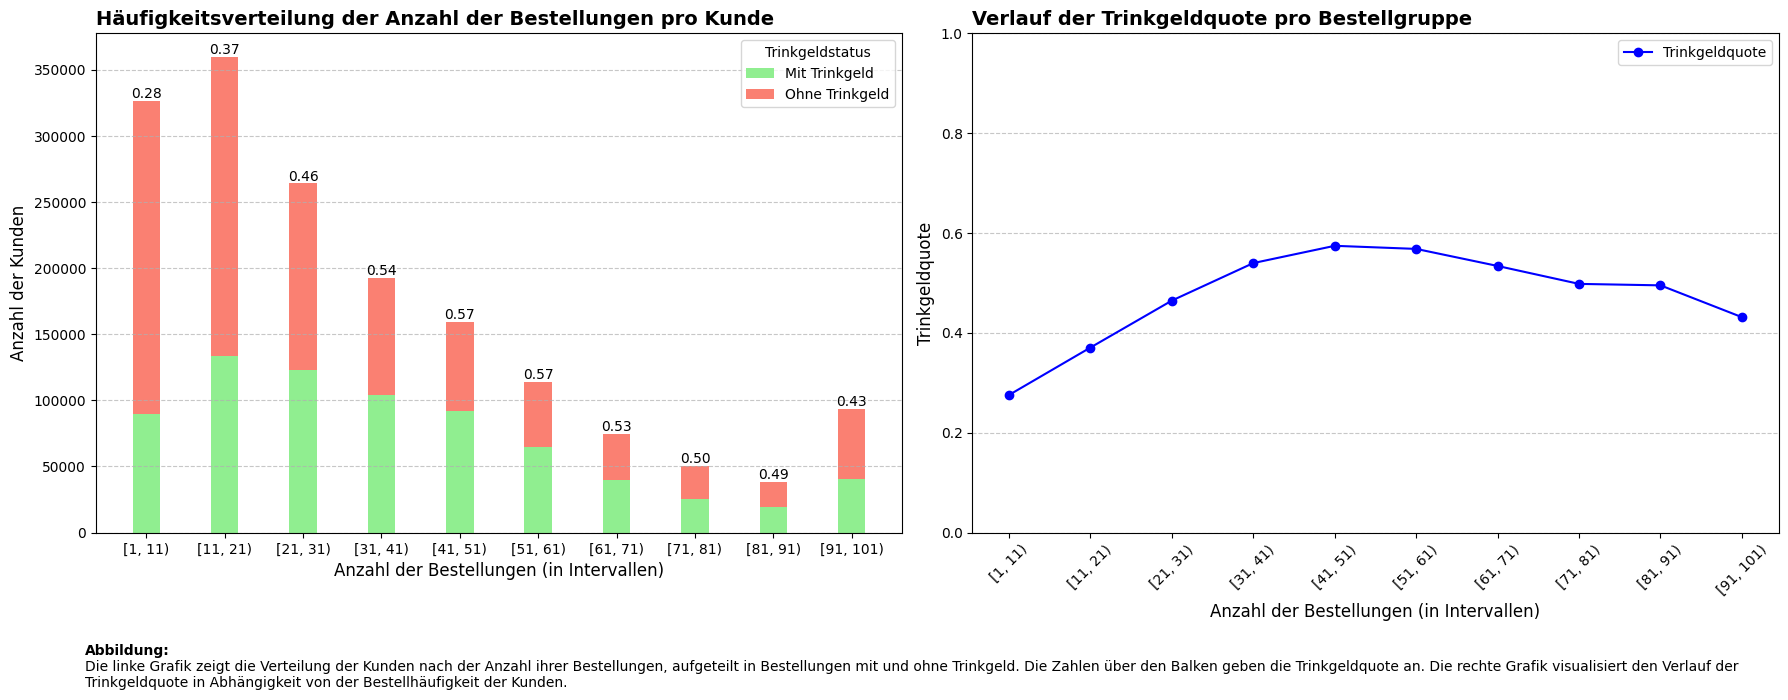

In [89]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Linker Plot: Gestapelte Balkendiagramme
bars_with_tips = ax1.bar(grouped_stats_df['order_group'].astype(str), grouped_stats_df['orders_with_tips'], 
                         width=0.35, color='lightgreen', label='Mit Trinkgeld')
bars_without_tips = ax1.bar(grouped_stats_df['order_group'].astype(str), grouped_stats_df['orders_without_tips'], 
                            width=0.35, bottom=grouped_stats_df['orders_with_tips'], 
                            color='salmon', label='Ohne Trinkgeld')

# Quotienten anzeigen
for i, rect in enumerate(bars_with_tips):
    total_height = rect.get_height() + bars_without_tips[i].get_height()
    ratio = grouped_stats_df['tips_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, total_height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom', fontsize=10)

# Formatierung linker Plot
ax1.set_title('Häufigkeitsverteilung der Anzahl der Bestellungen pro Kunde', 
              loc='left', weight='bold', fontsize=14)
ax1.set_xlabel('Anzahl der Bestellungen (in Intervallen)', fontsize=12)
ax1.set_ylabel('Anzahl der Kunden', fontsize=12)
ax1.legend(title='Trinkgeldstatus')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


# Rechter Plot: Liniendiagramm
ax2.plot(grouped_stats_df['order_group'].astype(str), grouped_stats_df['tips_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote pro Bestellgruppe', 
              loc='left', weight='bold', fontsize=14)
ax2.set_xlabel('Anzahl der Bestellungen (in Intervallen)', fontsize=12)
ax2.set_ylabel('Trinkgeldquote', fontsize=12)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


# Bildunterschrift
description = 'Die linke Grafik zeigt die Verteilung der Kunden nach der Anzahl ihrer Bestellungen, aufgeteilt in Bestellungen mit und ohne Trinkgeld. Die Zahlen über den Balken geben die Trinkgeldquote an. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote in Abhängigkeit von der Bestellhäufigkeit der Kunden.'
fig.text(0.05, -0.1, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.15, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [33]:
# Stelle sicher, dass 'order_group' eine reguläre Spalte ist (nicht der Index)
grouped_stats_df.reset_index(inplace=True)

# Setze 'order_group' als Index
crosstab = grouped_stats_df.set_index('order_group')[['orders_with_tips', 'orders_without_tips']]


In [34]:
# chi² test code
chi2, p, dof, expected = chi2_contingency(crosstab)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕
│ Metrik                │    Wert │
╞═══════════════════════╪═════════╡
│ Chi-Quadrat Statistik │ 74451.7 │
├───────────────────────┼─────────┤
│ p-Wert                │       0 │
├───────────────────────┼─────────┤
│ Freiheitsgrade        │       9 │
╘═══════════════════════╧═════════╛

Interpretation:
╒══════════════════╤═══════════════════════════════════════════════╕
│                  │                                               │
╞══════════════════╪═══════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang        │
├──────────────────┼───────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)       │
├──────────────────┼───────────────────────────────────────────────┤
│ Schlussfolgerung │ Department und Trinkgeldvergabe sind abhängig │
╘══════════════════╧═══════════════════════════════════════════════╛


### 📊 Detailanalyse der Trinkgeldquoten-Verteilung

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Verteilungsanalyse mittels Boxplot</h4> 
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Um ein tieferes Verständnis der Trinkgeldverteilung zu erlangen, analysieren wir die Streuung der 
        Trinkgeldquoten innerhalb verschiedener Kundengruppen mittels eines Boxplots.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungselemente:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Box:</strong> Zeigt das erste bis dritte Quartil mit dem Median</li>
            <li><strong>Whisker:</strong> Erstrecken sich bis zu den Extremwerten (ohne Ausreißer)</li>
            <li><strong>Punkte:</strong> Markieren statistische Ausreißer</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analysefokus:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Verteilung der Trinkgeldquoten in verschiedenen Bestellhäufigkeitsgruppen</li>
            <li>Identifikation von Ausreißern und Extremwerten</li>
            <li>Erkennung von Mustern in der Streuung der Trinkgeldquoten</li>
        </ul>
    </div>
</div>

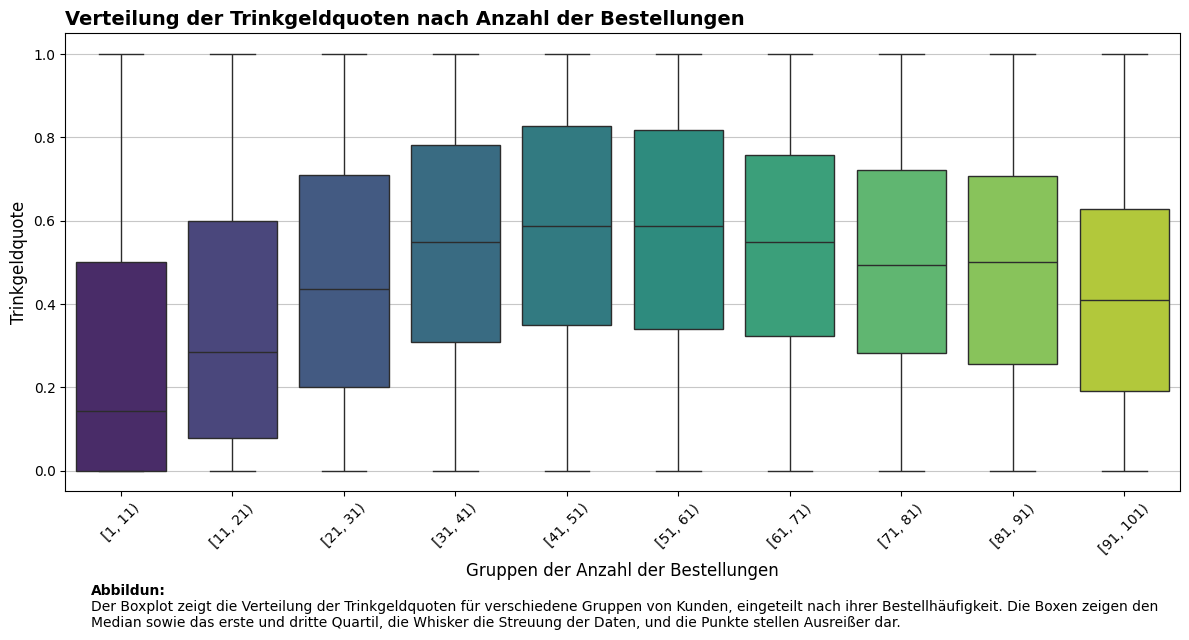

/tmp/ipykernel_57452/2377718759.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('order_group')['tip_ratio'].describe().reset_index()


| order_group   |   count |     mean |      std |   min |       25% |      50% |      75% |   max |
|:--------------|--------:|---------:|---------:|------:|----------:|---------:|---------:|------:|
| [1, 11)       |   53685 | 0.268971 | 0.329745 |     0 | 0         | 0.142857 | 0.5      |     1 |
| [11, 21)      |   24482 | 0.364814 | 0.319921 |     0 | 0.0785256 | 0.285714 | 0.6      |     1 |
| [21, 31)      |   10618 | 0.461799 | 0.306749 |     0 | 0.2       | 0.434783 | 0.708333 |     1 |
| [31, 41)      |    5491 | 0.538614 | 0.297895 |     0 | 0.307692  | 0.548387 | 0.78125  |     1 |
| [41, 51)      |    3537 | 0.57336  | 0.295694 |     0 | 0.348837  | 0.586957 | 0.826087 |     1 |
| [51, 61)      |    2072 | 0.56848  | 0.294252 |     0 | 0.339286  | 0.586207 | 0.818182 |     1 |
| [61, 71)      |    1147 | 0.534291 | 0.285655 |     0 | 0.322581  | 0.548387 | 0.757576 |     1 |
| [71, 81)      |     669 | 0.497768 | 0.279148 |     0 | 0.28169   | 0.493506 | 0.722222 |     1 |
| [81, 91)      |     452 | 0.49548  | 0.288117 |     0 | 0.255962  | 0.5      | 0.708224 |     1 |
| [91, 101)     |     951 | 0.431953 | 0.280161 |     0 | 0.191919  | 0.41     | 0.628263 |     1 |

In [35]:
# plot code
user_stats_df['order_group'] = pd.cut(
    user_stats_df['total_orders'],
    bins=range(1, 102, 10),
    right=False  
)

user_stats_df['tip_ratio'] = user_stats_df['orders_with_tips'] / user_stats_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='order_group', 
    y='tip_ratio', 
    palette='viridis',
    hue='order_group',
    legend=False,
    ax=ax
)

ax.set_title('Verteilung der Trinkgeldquoten nach Anzahl der Bestellungen', 
             loc='left', weight='bold', fontsize=14)
ax.set_xlabel('Gruppen der Anzahl der Bestellungen', fontsize=12)
ax.set_ylabel('Trinkgeldquote', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.7)

description = 'Der Boxplot zeigt die Verteilung der Trinkgeldquoten für verschiedene Gruppen von Kunden, eingeteilt nach ihrer Bestellhäufigkeit. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.08, 0, 'Abbildun:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('order_group')['tip_ratio'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


### 📊 Analyse des Trinkgeldverhaltens in Abhängigkeit der Bestellhäufigkeit

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Untersuchungsfokus</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Analyse des Bestellverhaltens über die Zeit untersuchen wir nun den Zusammenhang zwischen der 
        Bestellgröße (Anzahl der Produkte pro Bestellung) und dem Trinkgeldverhalten der Kunden.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungsaufbau:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Absolute Verteilung der Bestellungen nach Größe und Trinkgeldstatus</li>
            <li><strong>Rechter Plot:</strong> Entwicklung der Trinkgeldquote mit zunehmender Bestellgröße</li>
            <li>Gruppierung der Bestellungen nach Anzahl der enthaltenen Produkte</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Kernfragen der Analyse:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Gibt es einen Zusammenhang zwischen Bestellgröße und Trinkgeldwahrscheinlichkeit?</li>
            <li>Wie verteilen sich die Bestellgrößen im Gesamtdatensatz?</li>
            <li>Lassen sich kritische Schwellenwerte in der Bestellgröße identifizieren?</li>
        </ul>
    </div>
</div>

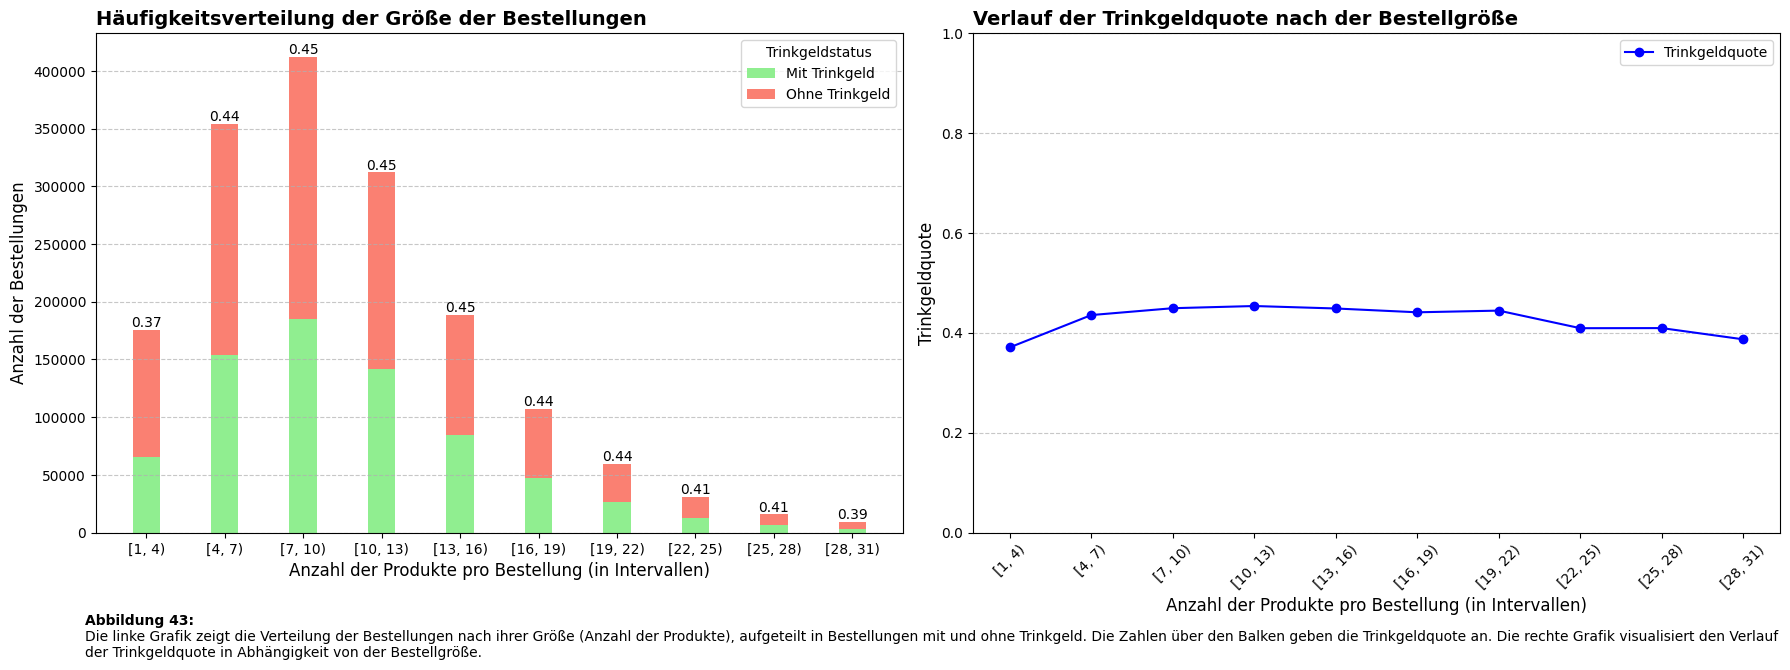

In [91]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bars_with_tips = ax1.bar(grouped_stats_df_item_count['item_count_group'].astype(str), 
                        grouped_stats_df_item_count['orders_with_tips'], 
                        width=0.35, color='lightgreen', label='Mit Trinkgeld')
bars_without_tips = ax1.bar(grouped_stats_df_item_count['item_count_group'].astype(str), 
                           grouped_stats_df_item_count['orders_without_tips'], 
                           width=0.35, bottom=grouped_stats_df_item_count['orders_with_tips'], 
                           color='salmon', label='Ohne Trinkgeld')

for i, rect in enumerate(bars_with_tips):
    total_height = rect.get_height() + bars_without_tips[i].get_height()
    ratio = grouped_stats_df_item_count['tips_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, total_height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom', fontsize=10)

ax1.set_title('Häufigkeitsverteilung der Größe der Bestellungen', 
              loc='left', weight='bold', fontsize=14)
ax1.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax1.set_ylabel('Anzahl der Bestellungen', fontsize=12)
ax1.legend(title='Trinkgeldstatus')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.plot(grouped_stats_df_item_count['item_count_group'].astype(str), 
         grouped_stats_df_item_count['tips_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach der Bestellgröße', 
              loc='left', weight='bold', fontsize=14)
ax2.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax2.set_ylabel('Trinkgeldquote', fontsize=12)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


description = 'Die linke Grafik zeigt die Verteilung der Bestellungen nach ihrer Größe (Anzahl der Produkte), aufgeteilt in Bestellungen mit und ohne Trinkgeld. Die Zahlen über den Balken geben die Trinkgeldquote an. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote in Abhängigkeit von der Bestellgröße.'
fig.text(0.05, -0.05, 'Abbildung 43:', weight='bold', ha='left')
fig.text(0.05, -0.1, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [37]:
# Stelle sicher, dass 'order_group' eine reguläre Spalte ist (nicht der Index)
grouped_stats_df_item_count.reset_index(inplace=True)

# Setze 'order_group' als Index
crosstab = grouped_stats_df_item_count.set_index('item_count_group')[['orders_with_tips', 'orders_without_tips']]

In [38]:
# chi² code
chi2, p_value, dof, expected = chi2_contingency(crosstab)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Anzahl der Bestellungen und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Anzahl der Bestellungen und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Chi-Quadrat Testergebnisse:
╒═══════════════════════╤════════╕
│ Metrik                │   Wert │
╞═══════════════════════╪════════╡
│ Chi-Quadrat Statistik │ 4097.7 │
├───────────────────────┼────────┤
│ p-Wert                │      0 │
├───────────────────────┼────────┤
│ Freiheitsgrade        │      9 │
╘═══════════════════════╧════════╛

Interpretation:
╒══════════════════╤════════════════════════════════════════════════════════════╕
│                  │                                                            │
╞══════════════════╪════════════════════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang                     │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)                    │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Schlussfolgerung │ Anzahl der Bestellungen und Trinkgeldvergabe

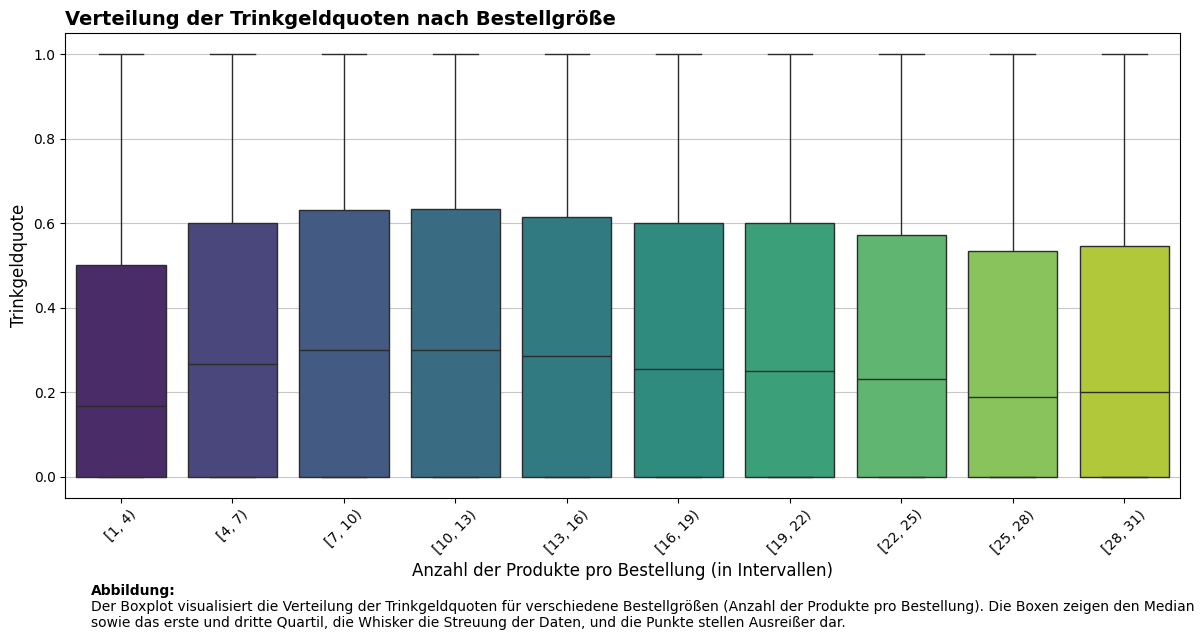

/tmp/ipykernel_57452/783550330.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('item_count_group')['tip_ratio'].describe().reset_index()


| item_count_group   |   count |     mean |      std |   min |   25% |      50% |      75% |   max |
|:-------------------|--------:|---------:|---------:|------:|------:|---------:|---------:|------:|
| [1, 4)             |   13178 | 0.290442 | 0.331754 |     0 |     0 | 0.166667 | 0.5      |     1 |
| [4, 7)             |   21991 | 0.351854 | 0.336874 |     0 |     0 | 0.266667 | 0.6      |     1 |
| [7, 10)            |   23822 | 0.367149 | 0.334939 |     0 |     0 | 0.3      | 0.631579 |     1 |
| [10, 13)           |   18155 | 0.369306 | 0.334755 |     0 |     0 | 0.3      | 0.634146 |     1 |
| [13, 16)           |   11259 | 0.359589 | 0.333961 |     0 |     0 | 0.285714 | 0.615385 |     1 |
| [16, 19)           |    6649 | 0.349186 | 0.332531 |     0 |     0 | 0.255102 | 0.6      |     1 |
| [19, 22)           |    3759 | 0.345208 | 0.336782 |     0 |     0 | 0.25     | 0.6      |     1 |
| [22, 25)           |    2022 | 0.322679 | 0.329247 |     0 |     0 | 0.230769 | 0.571429 |     1 |
| [25, 28)           |    1077 | 0.302422 | 0.330092 |     0 |     0 | 0.1875   | 0.533333 |     1 |
| [28, 31)           |     607 | 0.307518 | 0.328821 |     0 |     0 | 0.2      | 0.545455 |     1 |

In [39]:
# plot code
user_stats_df['item_count_group'] = pd.cut(
    user_stats_df['avg_order_size'],
    bins=range(1, 32, 3),
    right=False  
)

user_stats_df['tip_ratio'] = user_stats_df['orders_with_tips'] / user_stats_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='item_count_group', 
    y='tip_ratio', 
    palette='viridis',
    hue='item_count_group',
    legend=False,
    ax=ax
)

ax.set_title('Verteilung der Trinkgeldquoten nach Bestellgröße', 
             loc='left', weight='bold', fontsize=14)
ax.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax.set_ylabel('Trinkgeldquote', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.7)

description = 'Der Boxplot visualisiert die Verteilung der Trinkgeldquoten für verschiedene Bestellgrößen (Anzahl der Produkte pro Bestellung). Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.08, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('item_count_group')['tip_ratio'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


### 🥧 Kategorisierung der Kunden nach Trinkgeldverhalten

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Kundensegmentierung</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Um ein detaillierteres Verständnis des Kundenverhaltens zu erlangen, kategorisieren wir die Kunden 
        basierend auf ihrer individuellen Trinkgeldquote in fünf distinkte Gruppen.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Kategorien-Definition:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Nie Trinkgeld:</strong> Kunden mit 0% Trinkgeldquote</li>
            <li><strong>Selten Trinkgeld:</strong> Trinkgeldquote ≤ 25%</li>
            <li><strong>Gelegentlich Trinkgeld:</strong> Trinkgeldquote 26-75%</li>
            <li><strong>Häufig Trinkgeld:</strong> Trinkgeldquote 76-99%</li>
            <li><strong>Immer Trinkgeld:</strong> Trinkgeldquote 100%</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziele:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Identifikation der Hauptkundengruppen nach Trinkgeldverhalten</li>
            <li>Erkennung von Verhaltensmustern in der Kundenbasis</li>
            <li>Grundlage für gezielte Marketing- und Service-Strategien</li>
        </ul>
    </div>
</div>

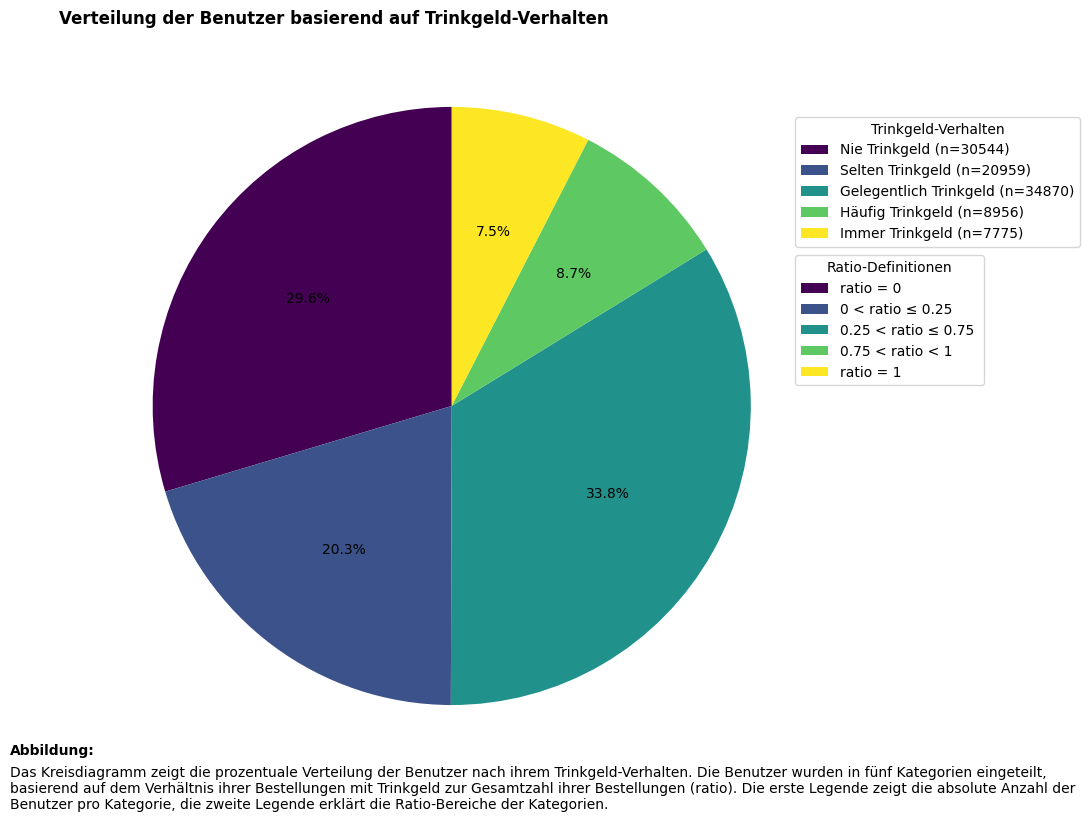

In [40]:
# plot code
def categorize_tip_ratio(ratio):
    if ratio == 0:
        return "Nie Trinkgeld"
    elif ratio == 1:
        return "Immer Trinkgeld"
    elif ratio <= 0.25:
        return "Selten Trinkgeld"
    elif ratio <= 0.75:
        return "Gelegentlich Trinkgeld"
    elif ratio < 1.0:
        return "Häufig Trinkgeld"
    else:
        return "immer Trinkgeld"

user_stats_df['tip_category'] = user_stats_df['tip_ratio'].apply(categorize_tip_ratio)

tip_category_counts = user_stats_df['tip_category'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.08)

category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                 "Häufig Trinkgeld", "Immer Trinkgeld"]

tip_category_counts = tip_category_counts.reindex(category_order)

colors = plt.cm.viridis(np.linspace(0, 1, len(category_order)))

wedges, texts, autotexts = ax.pie(
    tip_category_counts.values,
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90)

ax.set_title('Verteilung der Benutzer basierend auf Trinkgeld-Verhalten', 
             loc='left', weight='bold', x=-0.025)

legend_elements_1 = [
    Patch(facecolor=colors[i], label=f"{cat} (n={tip_category_counts[cat]})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Verhalten",
    loc="center left",
    bbox_to_anchor=(0.95, 0.8),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=colors[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen",
    loc='center left',
    bbox_to_anchor=(0.95, 0.615),
    frameon=True
)

ax.add_artist(legend_1)

description = 'Das Kreisdiagramm zeigt die prozentuale Verteilung der Benutzer nach ihrem Trinkgeld-Verhalten. Die Benutzer wurden in fünf Kategorien eingeteilt, basierend auf dem Verhältnis ihrer Bestellungen mit Trinkgeld zur Gesamtzahl ihrer Bestellungen (ratio). Die erste Legende zeigt die absolute Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien.'
fig.text(0.1, 0.05, 'Abbildung:', weight='bold', ha='left')
fig.text(0.1, -0.015, description, wrap=True)

plt.tight_layout()
plt.show()

### 📊 Analyse der Bestellhäufigkeit nach Trinkgeld-Kategorien

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Verteilungsanalyse</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Kategorisierung der Kunden nach ihrem Trinkgeldverhalten untersuchen wir nun, 
        wie sich die Anzahl der Bestellungen innerhalb dieser Gruppen verteilt.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungselemente:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Box:</strong> Zeigt IQR (25%-75% Quartil) mit Medianline</li>
            <li><strong>Whisker:</strong> Reichweite der Daten (ohne Ausreißer)</li>
            <li><strong>Punkte:</strong> Einzelne Ausreißer</li>
            <li><strong>Farbskala:</strong> Kategorien von "Nie" bis "Immer" Trinkgeld</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Untersuchungsfokus:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Zusammenhang zwischen Bestellhäufigkeit und Trinkgeldverhalten</li>
            <li>Identifikation von Unterschieden in der Bestellaktivität</li>
            <li>Erkennung von Ausreißern in den verschiedenen Kategorien</li>
        </ul>
    </div>
</div>

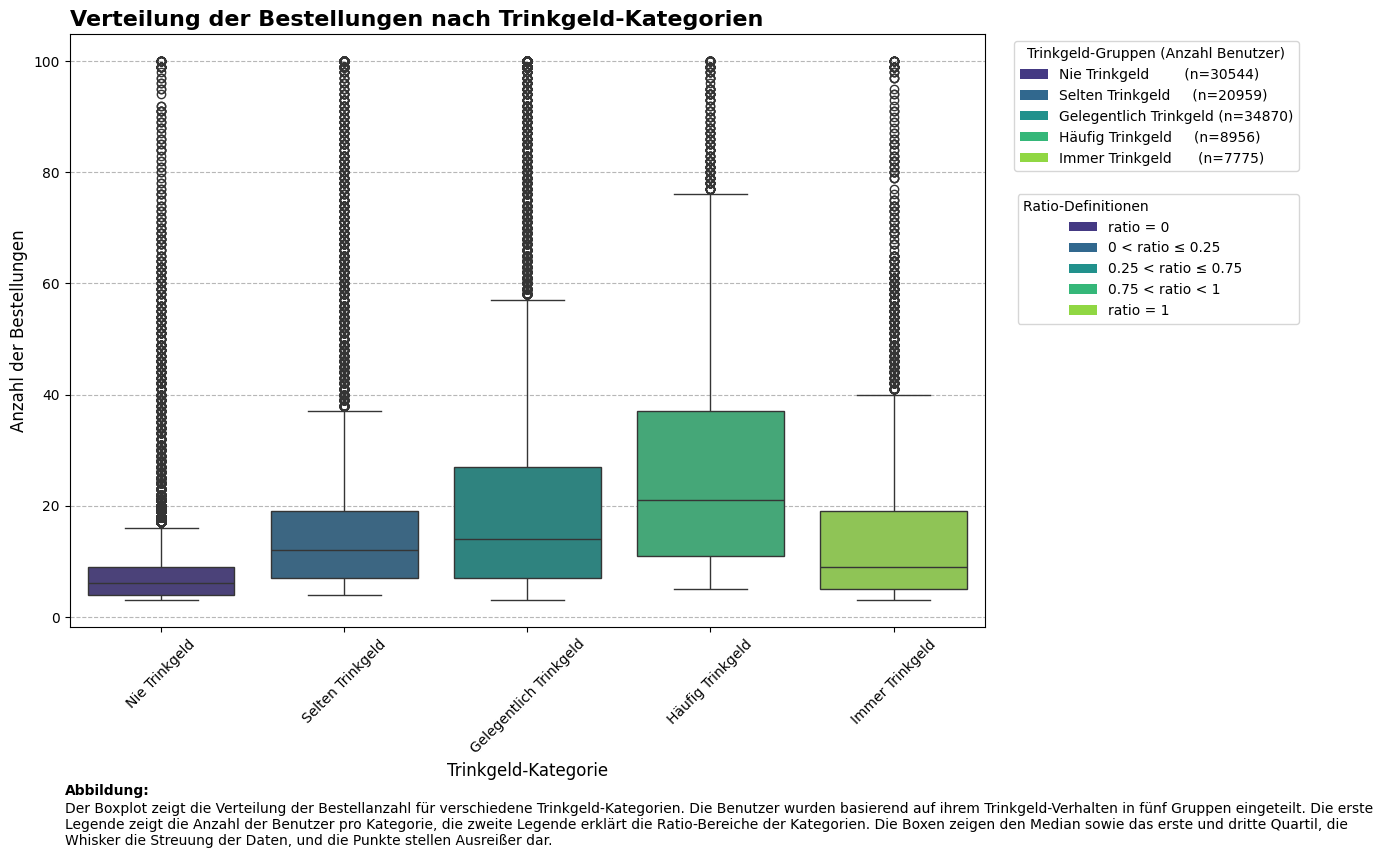

/tmp/ipykernel_57452/479350945.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('tip_category')['total_orders'].describe().reset_index()


| tip_category           |   count |     mean |      std |   min |   25% |   50% |   75% |   max |
|:-----------------------|--------:|---------:|---------:|------:|------:|------:|------:|------:|
| Nie Trinkgeld          |   30544 |  8.42267 |  8.31828 |     3 |     4 |     6 |     9 |   100 |
| Selten Trinkgeld       |   20959 | 16.1157  | 15.583   |     4 |     7 |    12 |    19 |   100 |
| Gelegentlich Trinkgeld |   34870 | 20.8696  | 19.0922  |     3 |     7 |    14 |    27 |   100 |
| Häufig Trinkgeld       |    8956 | 25.9238  | 19.3059  |     5 |    11 |    21 |    37 |   100 |
| Immer Trinkgeld        |    7775 | 15.1888  | 15.5573  |     3 |     5 |     9 |    19 |   100 |

In [41]:
# plot code
category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                  "Häufig Trinkgeld", "Immer Trinkgeld"]

group_counts = user_stats_df['tip_category'].value_counts()

user_stats_df['tip_category'] = pd.Categorical(user_stats_df['tip_category'], categories=category_order, ordered=True)
user_stats_df = user_stats_df.sort_values(by='tip_category')

fig, ax = plt.subplots(figsize=(14, 8))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='tip_category',
    y='total_orders',
    order=category_order,
    palette='viridis',
    ax=ax,
    hue='tip_category'
)

ax.set_title('Verteilung der Bestellungen nach Trinkgeld-Kategorien', 
             loc='left', weight='bold', fontsize=16)
ax.set_xlabel('Trinkgeld-Kategorie', fontsize=12)
ax.set_ylabel('Anzahl der Bestellungen', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

legend_elements_1 = [
    Patch(facecolor=sns.color_palette('viridis', len(category_order))[i], 
          label=f"{cat.ljust(20)} (n={group_counts[cat]:<3})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Gruppen (Anzahl Benutzer)".ljust(20),
    loc='upper right',
    bbox_to_anchor=(1.35, 1),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=sns.color_palette('viridis', len(ratio_explanations))[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen".ljust(51),
    loc='lower right',
    bbox_to_anchor=(1.35, 0.5),
    frameon=True
)

ax.add_artist(legend_1)
ax.grid(axis='y', linestyle='--', alpha=0.9)

description = 'Der Boxplot zeigt die Verteilung der Bestellanzahl für verschiedene Trinkgeld-Kategorien. Die Benutzer wurden basierend auf ihrem Trinkgeld-Verhalten in fünf Gruppen eingeteilt. Die erste Legende zeigt die Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('tip_category')['total_orders'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


### 📊 Analyse der durchschnittlichen Bestellgröße nach Trinkgeld-Kategorien

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Als letzten Aspekt unserer Analyse untersuchen wir den Zusammenhang zwischen der durchschnittlichen 
        Bestellgröße (Anzahl Produkte pro Bestellung) und dem Trinkgeldverhalten der Kunden.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Analyseaspekte:</strong>
        <ul style="margin: 10px 0;">
            <li>Vergleich der Bestellgrößen zwischen den Trinkgeld-Kategorien</li>
            <li>Untersuchung der Streuung innerhalb der Kategorien</li>
            <li>Identifikation möglicher Zusammenhänge zwischen Bestellgröße und Trinkgeldverhalten</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Zentrale Fragen:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Bestellen Kunden mit höherer Trinkgeldneigung durchschnittlich mehr Produkte?</li>
            <li>Gibt es charakteristische Unterschiede in der Bestellgröße zwischen den Kategorien?</li>
            <li>Welche Rolle spielt die Bestellgröße beim Trinkgeldverhalten?</li>
        </ul>
    </div>
</div>

/tmp/ipykernel_57452/884178474.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('tip_category')['avg_order_size'].describe().reset_index()


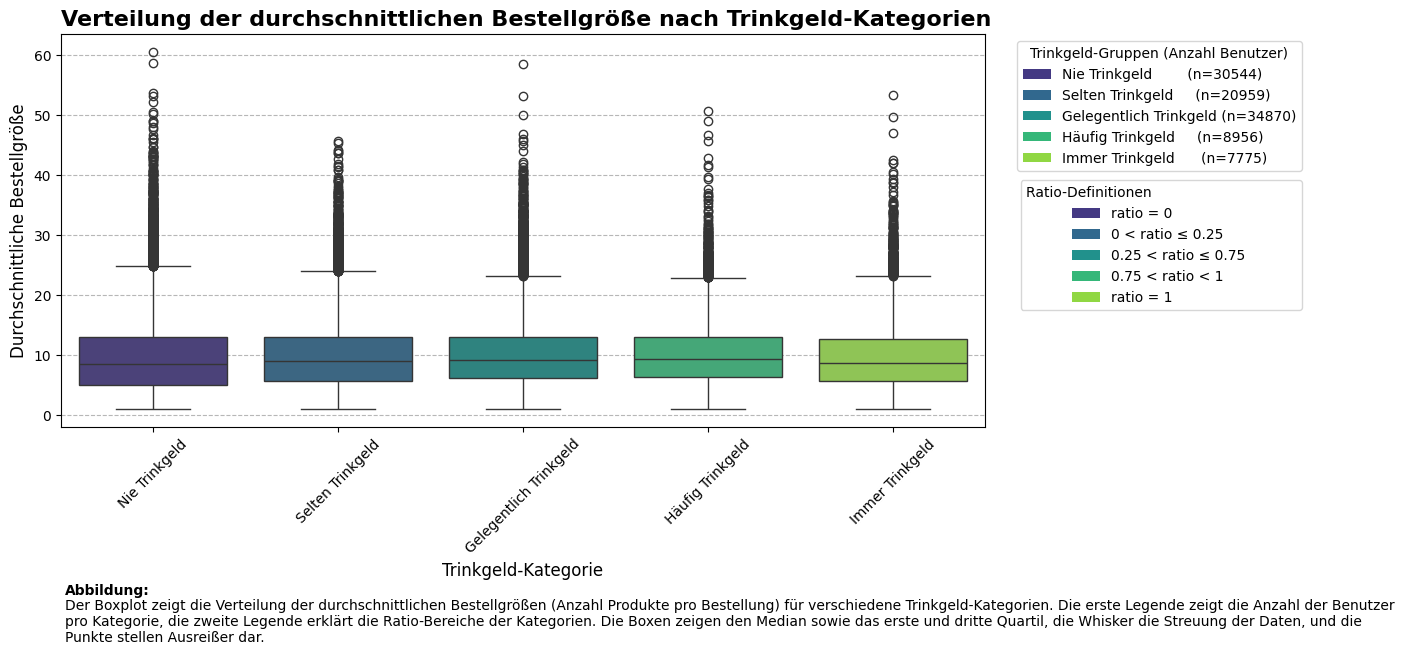

| tip_category           |   count |     mean |     std |   min |     25% |     50% |     75% |     max |
|:-----------------------|--------:|---------:|--------:|------:|--------:|--------:|--------:|--------:|
| Nie Trinkgeld          |   30544 |  9.77409 | 6.30377 |     1 | 5.11111 | 8.6     | 13      | 60.5    |
| Selten Trinkgeld       |   20959 | 10.0188  | 5.85337 |     1 | 5.75894 | 9       | 13.0625 | 45.75   |
| Gelegentlich Trinkgeld |   34870 | 10.1248  | 5.57082 |     1 | 6.16667 | 9.16667 | 13      | 58.5    |
| Häufig Trinkgeld       |    8956 | 10.2351  | 5.4301  |     1 | 6.3837  | 9.31401 | 13      | 50.7083 |
| Immer Trinkgeld        |    7775 |  9.81899 | 5.73614 |     1 | 5.71429 | 8.76471 | 12.7071 | 53.2759 |

In [43]:
# plot code
summary_stats = user_stats_df.groupby('tip_category')['avg_order_size'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)


fig, ax = plt.subplots(figsize=(14, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='tip_category',
    y='avg_order_size',
    order=category_order,
    palette='viridis',
    ax=ax,
    hue='tip_category'
)

ax.set_title('Verteilung der durchschnittlichen Bestellgröße nach Trinkgeld-Kategorien', 
             loc='left', weight='bold', fontsize=16)
ax.set_xlabel('Trinkgeld-Kategorie', fontsize=12)
ax.set_ylabel('Durchschnittliche Bestellgröße', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

legend_elements_1 = [
    Patch(facecolor=sns.color_palette('viridis', len(category_order))[i], 
          label=f"{cat.ljust(20)} (n={group_counts[cat]:<3})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Gruppen (Anzahl Benutzer)".ljust(20),
    loc='upper right',
    bbox_to_anchor=(1.35, 1),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=sns.color_palette('viridis', len(ratio_explanations))[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen".ljust(51),
    loc='lower right',
    bbox_to_anchor=(1.35, 0.28),
    frameon=True
)

ax.add_artist(legend_1)
ax.grid(axis='y', linestyle='--', alpha=0.9)

description = 'Der Boxplot zeigt die Verteilung der durchschnittlichen Bestellgrößen (Anzahl Produkte pro Bestellung) für verschiedene Trinkgeld-Kategorien. Die erste Legende zeigt die Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.075, description, wrap=True)

plt.tight_layout()
plt.show()

display(Markdown(markdown_table))


---
# <h2 id="fragen">Konkrete Fragen</h2> 



<h3 id="frage1">Frage 1: </h3>
Hängt die Wahrscheinlichkeit, dass bei einer Bestellung Trinkgeld gegeben wird, vom 
Trinkgeldverhalten bei früheren Bestellungen desselben Bestellers ab? 



> a) Gibt es einen Zusammenhang bezüglich der vorhergehenden Bestellung?  

In [44]:
result = session.query(Order.order_id,Order.user_id,Order.order_number ,Order.tips).all()

orders = pd.DataFrame(result, columns=['order_id',"user_id","order_number" ,'tip'])


In [45]:
orders= orders.sort_values(by=["user_id","order_number"])

# Spalte für vorherige und vor-vorherige Trinkgeldangaben
orders['tip_prev'] = orders.groupby('user_id')['tip'].shift(1)
orders['tip_prev2'] = orders.groupby('user_id')['tip'].shift(2)



In [46]:
pd.crosstab(orders['tip_prev'], orders['tip'], margins=True,normalize='all')

tip,False,True,All
tip_prev,,,
False,0.427425,0.130028,0.557452
True,0.131364,0.311183,0.442548
All,0.558789,0.441211,1.000000


In [47]:
pd.crosstab(orders['tip'], orders['tip_prev'], margins=True,normalize='columns')

tip_prev,False,True,All
tip,,,
False,0.766746,0.296836,0.558789
True,0.233254,0.703164,0.441211


Gibt ein Kunde bei der vorherigen Bestellung Trinkgeld, beträgt die Wahrscheinlichkeit für Trinkgeld bei der aktuellen Bestellung 71%, was auf einen Zusammenhang hinweist.

> b) Gibt es einen Zusammenhang bezüglich der vor-vorherigen Bestellung?

In [48]:
pd.crosstab(orders['tip'], orders['tip_prev2'], margins=True,normalize='columns')

tip_prev2,False,True,All
tip,,,
False,0.737784,0.324889,0.552248
True,0.262216,0.675111,0.447752


Ähnlich wie in a) beträgt die Wahrscheinlichkeit für die aktuelle Bestellung 68%, wenn der Kunde bei der vorvorherigen Bestellung Trinkgeld gegeben hat.

> c) Liefert das Trinkgeldverhalten der vor-vorhergehende Bestellung Informationen auch über das 
hinaus, was bereits aus der vorhergehenden Bestellung abgelesen werden kann?

In [49]:
pd.crosstab([orders['tip_prev2'], orders['tip_prev']],orders["tip"] ,margins=True,normalize='index')

tip                    False      True
tip_prev2 tip_prev                    
False     False     0.821642  0.178358
          True      0.470954  0.529046
True      False     0.582866  0.417134
          True      0.216545  0.783455
All                 0.552248  0.447752

Die höchste Trinkgeldwahrscheinlichkeit tritt auf, wenn tip_prev=True und tip_prev2=True, was zeigt, dass tip_prev2 unabhängig von tip_prev zusätzliche Informationen über das Trinkgeldverhalten liefert.


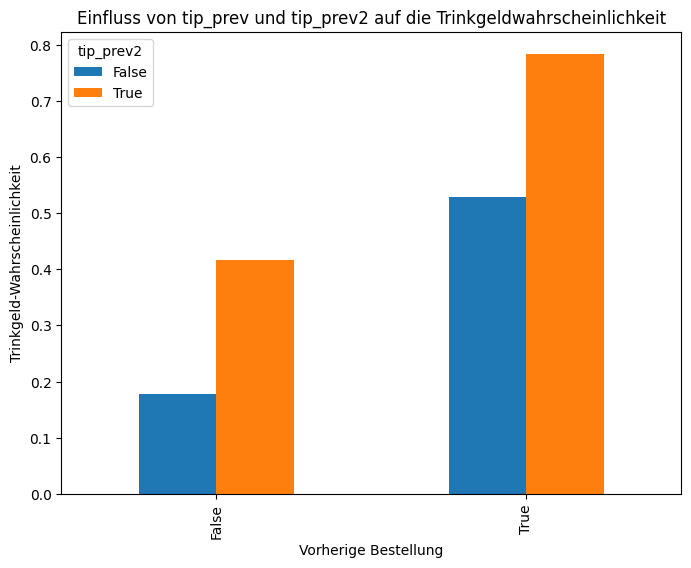

In [50]:
grouped = orders.groupby(['tip_prev', 'tip_prev2'])['tip'].mean().unstack()
grouped.plot(kind='bar', stacked=False, figsize=(8, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Einfluss von tip_prev und tip_prev2 auf die Trinkgeldwahrscheinlichkeit')
plt.ylabel('Trinkgeld-Wahrscheinlichkeit')
plt.xlabel('Vorherige Bestellung')
plt.legend(title='tip_prev2')
plt.show()

<div style="margin-top: 15px;">
        <strong>💡 Schlussfolgerungen:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Es besteht ein starker Zusammenhang zwischen dem Trinkgeldverhalten bei der vorherigen Bestellung und der aktuellen Bestellung.</li>
            <li>Wenn in den letzten beiden Bestellungen Trinkgeld gegeben wurde, erhöht sich die Wahrscheinlichkeit, dass auch in der aktuellen Bestellung Trinkgeld gegeben wird, zusätzlich und erreicht 78,88%.</li>
            </ul>
    </div>


### <h3 id ="frage2">Frage 2:</h3>

> a) Gibt es einen Zusammenhang zwischen dem Trinkgeldverhalten und den Departments, aus denen bestellt wird? 


In [51]:
aisles = pd.read_csv('../../Daten/aisles.csv')
departments = pd.read_csv('../../Daten/departments.csv')
order_products = pd.read_csv('../../Daten/oder_products_s.csv')
orders = pd.read_csv('../../Daten/oders_s.csv')
products = pd.read_csv('../../Daten/products.csv')
tips = pd.read_csv('../../Daten/tips.csv')

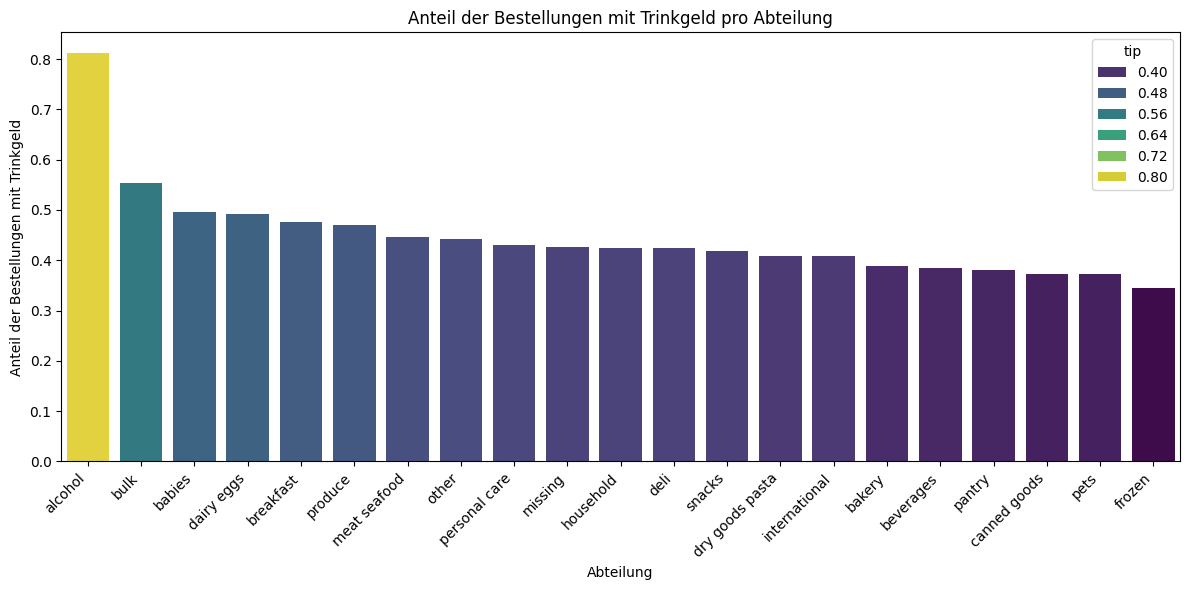

Chi-square Test Results
Chi2 statistic: 199364.85
P-value: 0.0000e+00
Degrees of Freedom: 20
Schlussfolgerung: Es besteht ein signifikanter Zusammenhang zwischen dem Trinkgeldverhalten und der Abteilung.


In [52]:
merged_data = (order_products
               .merge(products, on='product_id')
               .merge(departments, on='department_id')
               .merge(orders, on='order_id')
               .merge(tips, on='order_id'))

# Aggregate data: Percentage of orders with tips by department
department_tip_rate = (merged_data.groupby('department')['tip']
                       .mean()  # Calculate the proportion of True (tipped orders)
                       .reset_index()
                       .sort_values(by='tip', ascending=False))

# Visualize the percentage of tipped orders by department
plt.figure(figsize=(12, 6))
sns.barplot(data=department_tip_rate, x='department', y='tip', palette='viridis', hue='tip')
plt.xticks(rotation=45, ha='right')
plt.title('Anteil der Bestellungen mit Trinkgeld pro Abteilung')
plt.ylabel('Anteil der Bestellungen mit Trinkgeld')
plt.xlabel('Abteilung')
plt.tight_layout()
plt.show()

# Statistical analysis: Chi-square test to check association
# Create a contingency table: Count of tipped vs. non-tipped orders by department
contingency_table = pd.crosstab(merged_data['tip'], merged_data['department'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-square Test Results")
print(f"Chi2 statistic: {chi2:.2f}")
print(f"P-value: {p:.4e}")
print(f"Degrees of Freedom: {dof}")
if p < 0.05:
    print("Schlussfolgerung: Es besteht ein signifikanter Zusammenhang zwischen dem Trinkgeldverhalten und der Abteilung.")
else:
    print("Schlussfolgerung: Es besteht kein signifikanter Zusammenhang zwischen dem Trinkgeldverhalten und der Abteilung.")

/tmp/ipykernel_57452/3008101777.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=department_percentage, x='department', y='percentage', palette='viridis')


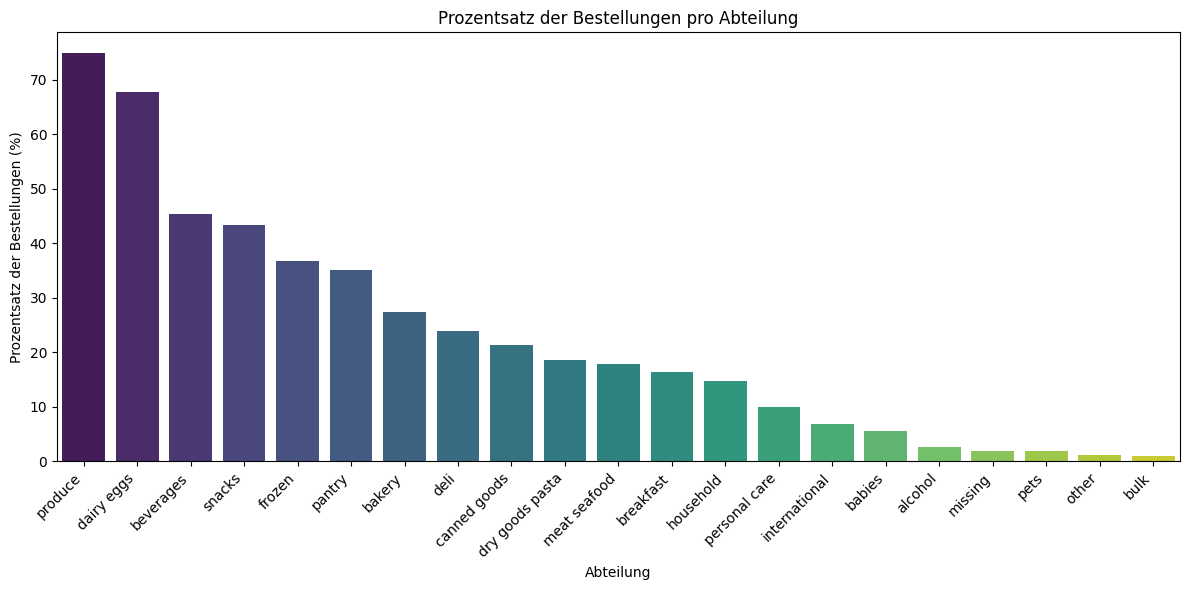

In [53]:
department_order_count = merged_data.groupby('department')['order_id'].nunique()

# Prozentuale Verteilung berechnen
total_orders = merged_data['order_id'].nunique()  # Gesamtzahl der Bestellungen
department_percentage = (department_order_count / total_orders) * 100

# Sortierung nach Prozentwerten
department_percentage = department_percentage.sort_values(ascending=False).reset_index()
department_percentage.columns = ['department', 'percentage']

# Visualisierung der prozentualen Verteilung
plt.figure(figsize=(12, 6))
sns.barplot(data=department_percentage, x='department', y='percentage', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Prozentsatz der Bestellungen pro Abteilung')
plt.ylabel('Prozentsatz der Bestellungen (%)')
plt.xlabel('Abteilung')
plt.tight_layout()
plt.show()

In [54]:
# Statistik über Produkte die mindestens 500 mal bestellt wurden: Gesamtbestellungen und Bestellungen mit Trinkgeld
products_stats = session.query(
    Product.product_name,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id) \
 .join(Order, Einkaufskorb.order_id == Order.order_id) \
 .group_by(Product.product_name) \
 .having(func.count(Order.order_id) >= 500).all()

products_df = pd.DataFrame(products_stats, columns=['product_name', 'total_orders', 'orders_with_tips'])
products_df['orders_without_tips'] = products_df['total_orders'] - products_df['orders_with_tips']
products_df['tip_ratio'] = products_df['orders_with_tips'] / products_df['total_orders']

products_top_10 = products_df.nlargest(10, 'tip_ratio').iloc[::-1]  # Top 10 nach Quote, Reihenfolge umkehren
products_flop_10 = products_df.nsmallest(10, 'tip_ratio')

def plot_products(products_data, title, ax):
    x = np.arange(len(products_data))

    ax.barh(x, products_data['orders_with_tips'], color='lightgreen', label='Mit Trinkgeld')
    ax.barh(x, products_data['orders_without_tips'], left=products_data['orders_with_tips'], color='salmon', label='Ohne Trinkgeld')

    ax.set_xlabel('Anzahl Bestellungen')
    ax.set_yticks(x)
    ax.set_yticklabels(products_data['product_name'])
    ax.set_title(title, loc='left', weight='bold')

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='grey', linestyle='--', linewidth=0.5)

    for i, product in enumerate(products_data['product_name']):
        ratio = products_data['tip_ratio'].iloc[i]
        total_orders = products_data['total_orders'].iloc[i]
        ax.text(
            products_data['orders_with_tips'].iloc[i] + products_data['orders_without_tips'].iloc[i] + 10, 
            i,  
            f'{ratio:.2f}',  
            va='center',  
            ha='left',  
            fontsize=10,
            color='black'
        )

    ax.legend(loc='upper right')


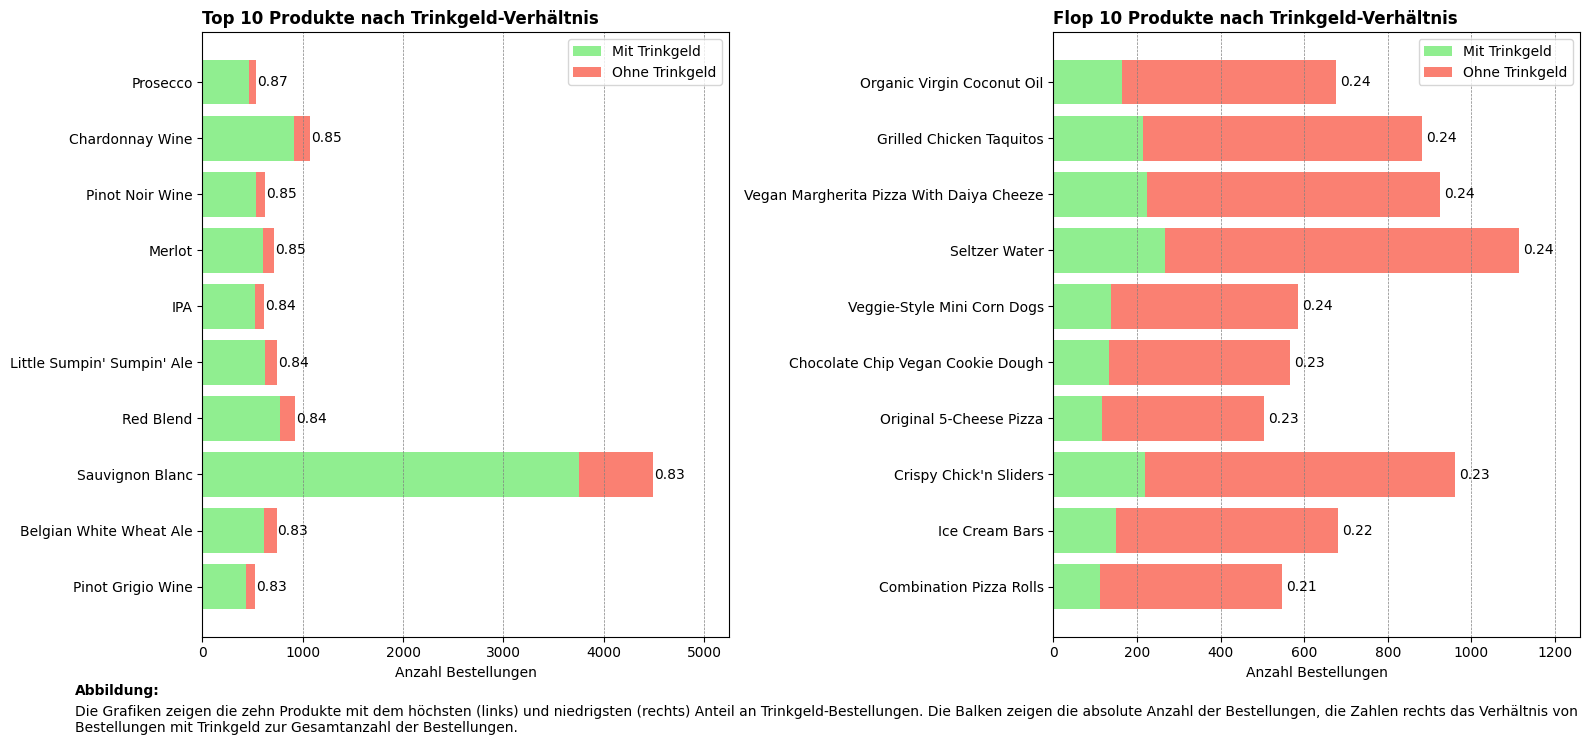

In [55]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
plt.subplots_adjust(left=0.08)

plot_products(products_top_10, 'Top 10 Produkte nach Trinkgeld-Verhältnis', ax1)

plot_products(products_flop_10, 'Flop 10 Produkte nach Trinkgeld-Verhältnis', ax2)

description = 'Die Grafiken zeigen die zehn Produkte mit dem höchsten (links) und niedrigsten (rechts) Anteil an Trinkgeld-Bestellungen. Die Balken zeigen die absolute Anzahl der Bestellungen, die Zahlen rechts das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen.'
fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report
import numpy as np

# Prepare data
# One-hot encode departments and top/bottom products
merged_data['is_top_product'] = merged_data['product_name'].isin(products_top_10['product_name'])
merged_data['is_flop_product'] = merged_data['product_name'].isin(products_flop_10['product_name'])

# One-hot encode department
encoder = OneHotEncoder(drop='first', sparse_output=False)
departments_encoded = encoder.fit_transform(merged_data[['department']])
department_columns = encoder.get_feature_names_out(['department'])

# Create feature set
X = pd.DataFrame(departments_encoded, columns=department_columns)
X['is_top_product'] = merged_data['is_top_product']
X['is_flop_product'] = merged_data['is_flop_product']

# Target variable
y = merged_data['tip']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model 1: Using department only
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train[department_columns], y_train)

# Model 2: Adding specific products
model_2 = LogisticRegression(max_iter=1000)
model_2.fit(X_train, y_train)

# Evaluate models
log_loss_1 = log_loss(y_test, model_1.predict_proba(X_test[department_columns]))
log_loss_2 = log_loss(y_test, model_2.predict_proba(X_test))

print(f"Log Loss (Model 1 - Department Only): {log_loss_1:.7f}")
print(f"Log Loss (Model 2 - Department + Products): {log_loss_2:.7f}")

# Compare models
if log_loss_2 < log_loss_1:
    print("Adding specific products improves the model, indicating they have an additional effect on tipping probability.")
elif log_loss_1 == log_loss_1:
    print("Same result")
else:
    print("Spezi")

# Optional: Examine coefficients for interpretation
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_2.coef_[0]
}).sort_values(by='Coefficient', ascending=False)


print(coefficients)

Log Loss (Model 1 - Department Only): 0.6795520
Log Loss (Model 2 - Department + Products): 0.6796556
Same result
                       Feature  Coefficient
20              is_top_product     2.197954
21             is_flop_product    -0.729557
4              department_bulk    -1.068955
0            department_babies    -1.165463
6        department_dairy eggs    -1.189687
3         department_breakfast    -1.252901
18          department_produce    -1.273836
12     department_meat seafood    -1.365133
13          department_missing    -1.416941
16    department_personal care    -1.432830
10        department_household    -1.451519
7              department_deli    -1.460532
19           department_snacks    -1.481783
11    department_international    -1.505160
14            department_other    -1.519313
8   department_dry goods pasta    -1.525277
1            department_bakery    -1.605517
2         department_beverages    -1.630309
15           department_pantry    -1.640273
5     

Da der Unterschied im Log Loss zwischen Modell 1 (nur Abteilungen) und Modell 2 (Abteilungen + Produkte) minimal ist, lässt sich schlussfolgern, dass die spezifischen Produkte keinen signifikanten zusätzlichen Einfluss auf die Trinkgeldwahrscheinlichkeit haben. Die geringe Verbesserung deutet darauf hin, dass die Abteilung als alleiniger Faktor bereits ausreichend für die Vorhersage der Trinkgeldwahrscheinlichkeit ist.


### <h3 id="frage3">Frage 3: </h3>
Gibt es einen Zusammenhang zwischen dem Trinkgeldverhalten und der Tageszeit, dem 
Wochentag, oder dem Zeitabstand zur vorhergehenden Bestellung?


#### Tageszeit & Trinkgeldverhalten

In [57]:
# Query: Anzahl der Bestellungen pro Wochentag
result_dow = session.query(
    Order.day_of_the_week,
    func.count().label('total_orders'),  # Gesamtzahl der Bestellungen
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  # Anzahl der Bestellungen mit Trinkgeld (True = 1, False = 0)
).group_by(Order.day_of_the_week).all()

result_dow_tips = session.query(
    Order.day_of_the_week,
    func.sum(case((Order.tips == True, 1), else_=0)).label('tips_given'),  # Anzahl Bestellungen mit Trinkgeld
    func.sum(case((Order.tips == False, 1), else_=0)).label('no_tips')    # Anzahl Bestellungen ohne Trinkgeld
).group_by(Order.day_of_the_week).all()

### ⏰ Zeitliche Analyse des Trinkgeldverhaltens

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Untersuchung zeitlicher Muster</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        In diesem Abschnitt untersuchen wir die zeitlichen Aspekte des Trinkgeldverhaltens, beginnend mit 
        der Analyse der Wochentage. Ziel ist es, mögliche Muster und Zusammenhänge zwischen dem Zeitpunkt 
        der Bestellung und der Trinkgeldvergabe zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsaufbau:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Absolute Verteilung der Bestellungen nach Wochentagen</li>
            <li><strong>Rechter Plot:</strong> Trinkgeldquote für jeden Wochentag</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Kernfragen:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Gibt es Wochentage mit besonders hoher/niedriger Bestellaktivität?</li>
            <li>Unterscheidet sich die Trinkgeldbereitschaft an verschiedenen Wochentagen?</li>
            <li>Lassen sich wiederkehrende Muster im Wochenverlauf erkennen?</li>
        </ul>
    </div>
</div>

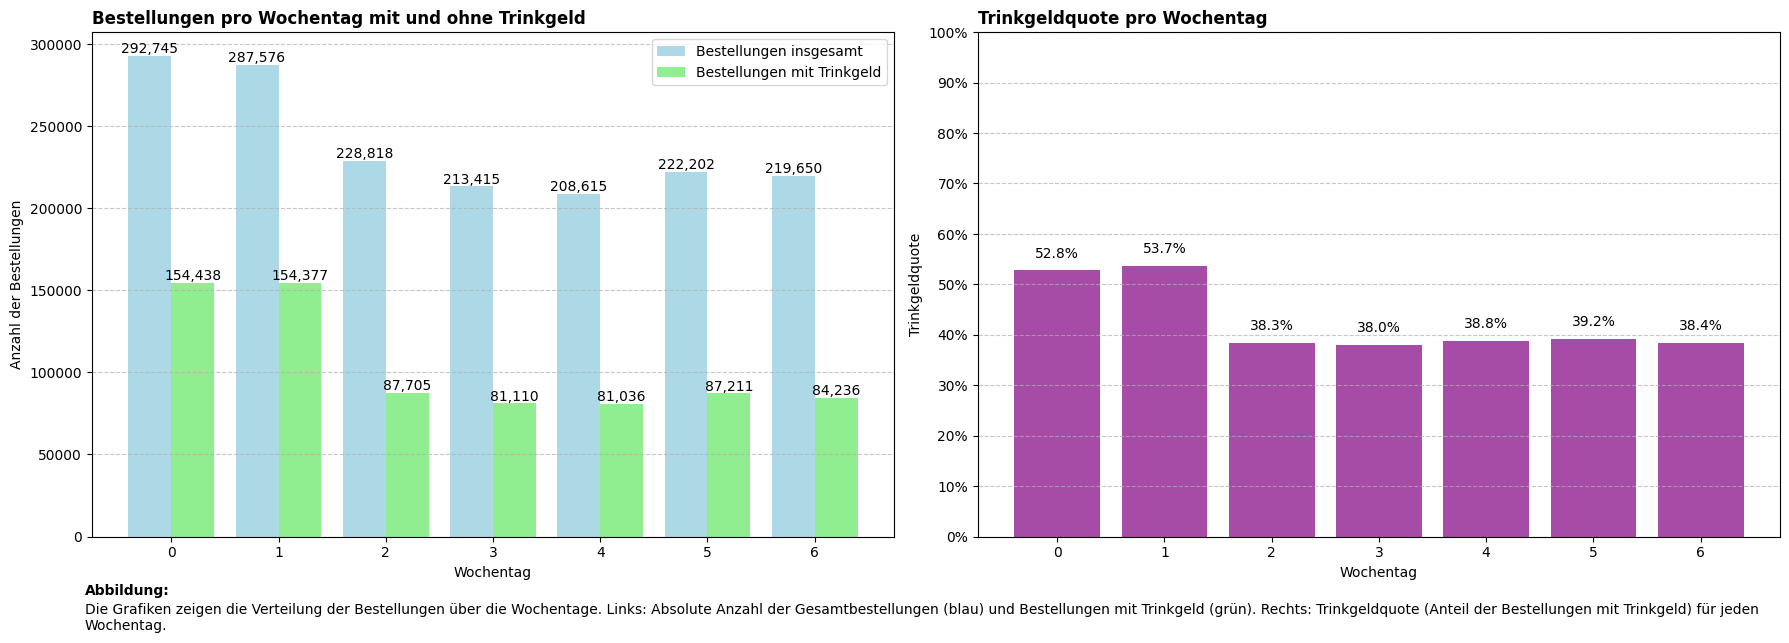

In [58]:
# plot code
days = [row.day_of_the_week for row in result_dow]
total_orders = [row.total_orders for row in result_dow]
total_tips = [row.total_tips if row.total_tips else 0 for row in result_dow]
tip_ratios = [row.total_tips / row.total_orders if row.total_orders > 0 else 0 for row in result_dow]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
width = 0.4
x = range(len(days))

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
bars1 = ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', color='lightblue')
bars2 = ax1.bar([i + width for i in x], total_tips, width, label='Bestellungen mit Trinkgeld', 
                color='lightgreen')

# Formatierung Diagramm 1
ax1.set_xlabel('Wochentag')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Wochentag mit und ohne Trinkgeld', 
              loc='left', weight='bold')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(days, rotation=0)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Werte über den Balken für Diagramm 1
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Diagramm 2: Tip-Quote
bars3 = ax2.bar(days, tip_ratios, color='purple', alpha=0.7)

# Formatierung Diagramm 2
ax2.set_xlabel('Wochentag')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Trinkgeldquote pro Wochentag', 
              loc='left', weight='bold')
ax2.set_ylim(0, 1)
ax2.set_yticks([i / 10 for i in range(0, 11)])
ax2.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Werte über den Balken für Diagramm 2
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f'{height:.1%}', ha='center', va='bottom', fontsize=10)

# Bildunterschrift
description = ('Die Grafiken zeigen die Verteilung der Bestellungen über die Wochentage. '
              'Links: Absolute Anzahl der Gesamtbestellungen (blau) und Bestellungen mit Trinkgeld (grün). '
              'Rechts: Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) für jeden Wochentag.')

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

plt.tight_layout()
plt.show()

In [59]:
data = [
    {'day_of_the_week': row[0], 'tips_given': row[1], 'no_tips': row[2]}
    for row in result_dow_tips
]
df = pd.DataFrame(data)

# Kontingenztabelle erstellen
contingency_table = df.set_index('day_of_the_week')[['tips_given', 'no_tips']]

In [60]:
# Chi-Quadrat-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = contingency_table.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
table_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(table_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
table_results = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(table_results))



Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                     154438 |                 127755   |                  138307 |                164990 |
|           1 |                     154377 |                 125499   |                  133199 |                162077 |
|           2 |                      87705 |                  99857.1 |                  141113 |                128961 |
|           3 |                      81110 |                  93135.2 |                  132305 |                120280 |
|           4 |                      81036 |                  91040.4 |                  127579 |                117575 |
|           5 |                      87211 |                  96969.8 |                  134991 |                125232 |
|           6 |                      84236 |                  95856.1 |                  135414 |                123794 |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 33249.758 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 6         |
| Signifikanz           | Ja        |

### Tageszeit & Trinkgeldverhalten

In [61]:
result_hours = session.query(
    Order.hour_of_day,
    func.count().label('total_orders'),  # Gesamtzahl der Bestellungen
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  # Anzahl der Bestellungen mit Trinkgeld (True = 1, False = 0)
).group_by(Order.hour_of_day).all()

result_hours_tips = session.query(
    Order.hour_of_day,
    func.sum(case((Order.tips == True, 1), else_=0)).label('tips_given'),  # Anzahl Bestellungen mit Trinkgeld
    func.sum(case((Order.tips == False, 1), else_=0)).label('no_tips')    # Anzahl Bestellungen ohne Trinkgeld
).group_by(Order.hour_of_day).all()

### ⏰ Analyse des Trinkgeldverhaltens im Tagesverlauf

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Stundenbasierte Untersuchung</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Analyse der Wochentage betrachten wir nun die Verteilung der Bestellungen und des 
        Trinkgeldverhaltens im Verlauf eines Tages. Diese feingranularere zeitliche Analyse könnte 
        wichtige Einblicke in das Kundenverhalten zu verschiedenen Tageszeiten liefern.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsaufbau:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Absolute Verteilung der Bestellungen nach Stunden</li>
            <li><strong>Rechter Plot:</strong> Trinkgeldquote für jede Stunde des Tages</li>
            <li>24-Stunden-Format für präzise Zeitdarstellung</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Kernfragen:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Gibt es Stoßzeiten für Bestellungen?</li>
            <li>Variiert die Trinkgeldbereitschaft zu verschiedenen Tageszeiten?</li>
            <li>Lassen sich typische Muster (z.B. Mittags-/Abendspitzen) erkennen?</li>
            <li>Gibt es Zusammenhänge zwischen Bestellvolumen und Trinkgeldquote?</li>
        </ul>
    </div>
</div>

In [62]:
result_hours_data = [
    [row.hour_of_day, row.total_orders, row.total_tips, f"{row.total_tips / row.total_orders:.2%}"]
    for row in result_hours
]
headers_hours = ["Stunde", "Bestellungen gesamt", "Mit Trinkgeld", "Trinkgeldquote (%)"]

print("\nBestellungen pro Stunde:")
result_hours_markdown = tabulate(result_hours_data, headers=headers_hours, tablefmt="pipe")
display(Markdown(result_hours_markdown))


Bestellungen pro Stunde:


|   Stunde |   Bestellungen gesamt |   Mit Trinkgeld | Trinkgeldquote (%)   |
|---------:|----------------------:|----------------:|:---------------------|
|        0 |                 11224 |            6003 | 53.48%               |
|        1 |                  6211 |            3244 | 52.23%               |
|        2 |                  3773 |            1931 | 51.18%               |
|        3 |                  2762 |            1397 | 50.58%               |
|        4 |                  2748 |            1406 | 51.16%               |
|        5 |                  4764 |            2005 | 42.09%               |
|        6 |                 15004 |            6462 | 43.07%               |
|        7 |                 45141 |           19897 | 44.08%               |
|        8 |                 87513 |           39013 | 44.58%               |
|        9 |                125904 |           56300 | 44.72%               |
|       10 |                141401 |           61461 | 43.47%               |
|       11 |                139520 |           58575 | 41.98%               |
|       12 |                133612 |           55220 | 41.33%               |
|       13 |                136575 |           56133 | 41.10%               |
|       14 |                138816 |           57426 | 41.37%               |
|       15 |                138279 |           56499 | 40.86%               |
|       16 |                133434 |           54224 | 40.64%               |
|       17 |                110832 |           44257 | 39.93%               |
|       18 |                 88464 |           35118 | 39.70%               |
|       19 |                 67899 |           36331 | 53.51%               |
|       20 |                 50955 |           27821 | 54.60%               |
|       21 |                 38382 |           21782 | 56.75%               |
|       22 |                 30195 |           16934 | 56.08%               |
|       23 |                 19613 |           10674 | 54.42%               |

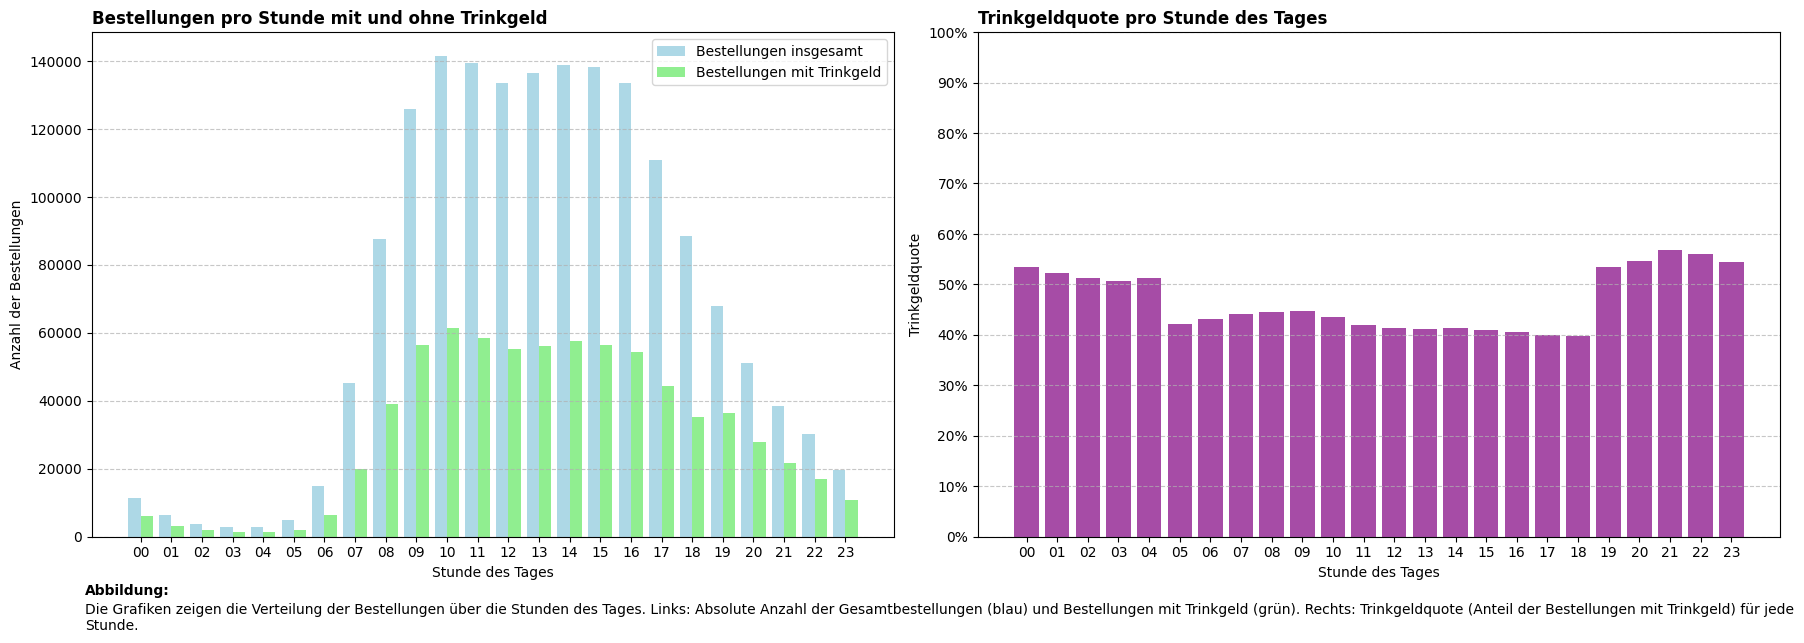

In [63]:
# Daten für das erste Diagramm
hours = [row.hour_of_day for row in result_hours]
total_orders = [row.total_orders for row in result_hours]
total_tips = [row.total_tips if row.total_tips else 0 for row in result_hours]

# Berechnung der Tip-Quote für das zweite Diagramm
tip_ratios = [row.total_tips / row.total_orders if row.total_orders > 0 else 0 for row in result_hours]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
width = 0.4
x = range(len(hours))

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
bars1 = ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', color='lightblue')
bars2 = ax1.bar([i + width for i in x], total_tips, width, label='Bestellungen mit Trinkgeld', 
                color='lightgreen')

# Formatierung Diagramm 1
ax1.set_xlabel('Stunde des Tages')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Stunde mit und ohne Trinkgeld', 
              loc='left', weight='bold')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels([f"{h:02d}" for h in hours])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Diagramm 2: Trinkgeldquote
bars3 = ax2.bar(hours, tip_ratios, color='purple', alpha=0.7)

# Formatierung Diagramm 2
ax2.set_xlabel('Stunde des Tages')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Trinkgeldquote pro Stunde des Tages', 
              loc='left', weight='bold')
ax2.set_ylim(0, 1)
ax2.set_yticks([i / 10 for i in range(0, 11)])
ax2.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax2.set_xticks(hours)
ax2.set_xticklabels([f"{h:02d}" for h in hours])
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Bildunterschrift
description = ('Die Grafiken zeigen die Verteilung der Bestellungen über die Stunden des Tages. '
              'Links: Absolute Anzahl der Gesamtbestellungen (blau) und Bestellungen mit Trinkgeld (grün). '
              'Rechts: Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) für jede Stunde.')

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

plt.tight_layout()
plt.show()

In [64]:
data = [
    {'hour_of_day': row[0], 'tips_given': row[1], 'no_tips': row[2]}
    for row in result_hours_tips
]
df = pd.DataFrame(data)

# Kontingenztabelle erstellen
contingency_table = df.set_index('hour_of_day')[['tips_given', 'no_tips']]

In [65]:
# Chi-Quadrat-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = contingency_table.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
comparison_data_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(comparison_data_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
test_results_markdown = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(test_results_markdown))


Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                       6003 |                  4898.2  |                    5221 |               6325.8  |
|           1 |                       3244 |                  2710.51 |                    2967 |               3500.49 |
|           2 |                       1931 |                  1646.55 |                    1842 |               2126.45 |
|           3 |                       1397 |                  1205.35 |                    1365 |               1556.65 |
|           4 |                       1406 |                  1199.24 |                    1342 |               1548.76 |
|           5 |                       2005 |                  2079.03 |                    2759 |               2684.97 |
|           6 |                       6462 |                  6547.81 |                    8542 |               8456.19 |
|           7 |                      19897 |                 19699.7  |                   25244 |              25441.3  |
|           8 |                      39013 |                 38191    |                   48500 |              49322    |
|           9 |                      56300 |                 54945    |                   69604 |              70959    |
|          10 |                      61461 |                 61708    |                   79940 |              79693    |
|          11 |                      58575 |                 60887.1  |                   80945 |              78632.9  |
|          12 |                      55220 |                 58308.8  |                   78392 |              75303.2  |
|          13 |                      56133 |                 59601.9  |                   80442 |              76973.1  |
|          14 |                      57426 |                 60579.9  |                   81390 |              78236.1  |
|          15 |                      56499 |                 60345.5  |                   81780 |              77933.5  |
|          16 |                      54224 |                 58231.1  |                   79210 |              75202.9  |
|          17 |                      44257 |                 48367.5  |                   66575 |              62464.5  |
|          18 |                      35118 |                 38606    |                   53346 |              49858    |
|          19 |                      36331 |                 29631.4  |                   31568 |              38267.6  |
|          20 |                      27821 |                 22237    |                   23134 |              28718    |
|          21 |                      21782 |                 16750.1  |                   16600 |              21631.9  |
|          22 |                      16934 |                 13177.2  |                   13261 |              17017.8  |
|          23 |                      10674 |                  8559.19 |                    8939 |              11053.8  |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 14819.908 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 23        |
| Signifikanz           | Ja        |

In [66]:
result_hours_days = session.query(
    Order.hour_of_day,
    Order.day_of_the_week,
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  
).group_by(Order.hour_of_day, Order.day_of_the_week).all()

# Daten sammeln
data = []
for row in result_hours_days:
    tip_quote = row.total_tips / row.total_orders if row.total_orders else 0
    data.append([
        row.hour_of_day,
        row.total_orders,
        row.total_tips,
        f"{tip_quote:.2f}"  # Formatierte Trinkgeldquote
    ])


### 🎯 Kombinierte Analyse von Wochentag und Tageszeit

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Zweidimensionale Zeitanalyse</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der separaten Betrachtung von Wochentagen und Tageszeiten untersuchen wir nun deren 
        Wechselwirkung mittels einer detaillierten Heatmap-Analyse. Diese ermöglicht es uns, zeitliche 
        "Hotspots" für Trinkgeldzahlungen zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsdetails:</strong>
        <ul style="margin: 10px 0;">
            <li>X-Achse: 24 Stunden eines Tages</li>
            <li>Y-Achse: Wochentage</li>
            <li>Farbintensität: Höhe der Trinkgeldquote</li>
            <li>Zahlenwerte: Exakte Trinkgeldquote in den jeweiligen Zeitfenstern</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Untersuchungsziele:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Identifikation von Zeitkombinationen mit besonders hoher/niedriger Trinkgeldquote</li>
            <li>Erkennung von Mustern und Anomalien</li>
            <li>Verständnis der Interaktion zwischen Wochentag und Tageszeit</li>
            <li>Basis für gezieltere zeitliche Geschäftsstrategien</li>
        </ul>
    </div>
</div>

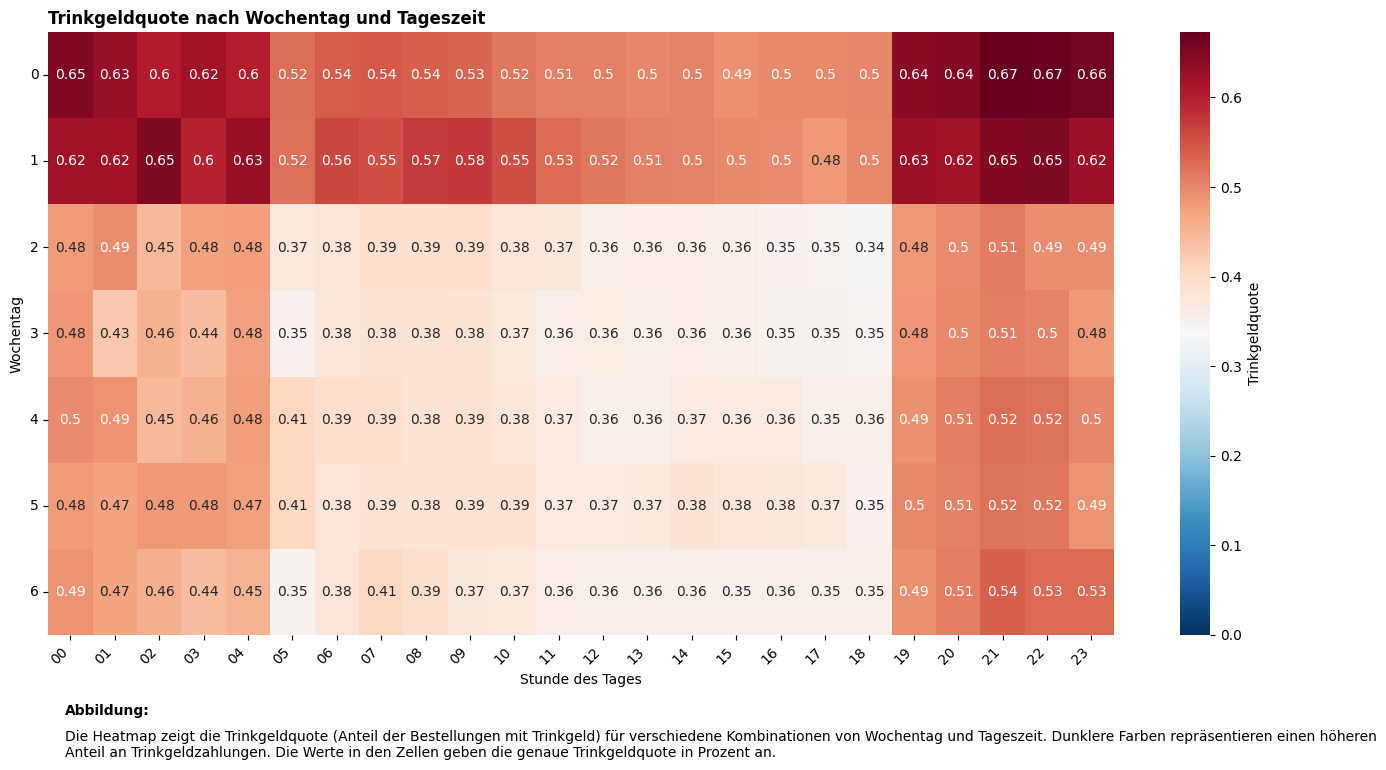

In [67]:

data = {
    'hour_of_day': [row.hour_of_day for row in result_hours_days],
    'day_of_the_week': [row.day_of_the_week for row in result_hours_days],  # Originale numerische Werte beibehalten
    'total_orders': [row.total_orders for row in result_hours_days],
    'total_tips': [row.total_tips if row.total_tips else 0 for row in result_hours_days],
}
df = pd.DataFrame(data)

# Zusätzliche Spalte für Tip-Quote berechnen
df['tip_ratio'] = df['total_tips'] / df['total_orders']

# Pivot-Tabelle erstellen (Stunden als Spalten, Wochentage als Zeilen)
heatmap_data = df.pivot(index='day_of_the_week', columns='hour_of_day', values='tip_ratio')

# Heatmap erstellen
fig, ax = plt.subplots(figsize=(14, 8))
plt.subplots_adjust(left=0.08)

# Pivot-Tabelle erstellen
heatmap_data = df.pivot(index='day_of_the_week', 
                       columns='hour_of_day', 
                       values='tip_ratio')

# Maximalen Wert finden für Farbskala
vmax = np.nanmax(heatmap_data.values)

# Heatmap erstellen
sns.heatmap(heatmap_data,
            annot=True,
            cmap='RdBu_r',  # Konsistente Farbpalette
            cbar_kws={'label': 'Trinkgeldquote'},
            xticklabels=[f"{int(h):02d}" for h in heatmap_data.columns],  # Führende Null für Stunden
            vmin=0,
            vmax=vmax,
            ax=ax)

# Titel und Achsenbeschriftungen
ax.set_title('Trinkgeldquote nach Wochentag und Tageszeit', 
             loc='left', 
             weight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Wochentag')

# Achsenbeschriftungen formatieren
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Bildunterschrift
description = ('Die Heatmap zeigt die Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) '
              'für verschiedene Kombinationen von Wochentag und Tageszeit. '
              'Dunklere Farben repräsentieren einen höheren Anteil an Trinkgeldzahlungen. '
              'Die Werte in den Zellen geben die genaue Trinkgeldquote in Prozent an.')

fig.text(0.05, 0.1, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, 0.05, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

### Abstand vorheriger Bestellung & Trinkgeldverhalten

In [68]:
# Query: Zähle die Anzahl der Bestellungen mit und ohne Trinkgeld basierend auf den Tagen seit der vorherigen Bestellung
result = session.query(
    Order.days_since_prior_order,
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  
).group_by(Order.days_since_prior_order).all()

result_test = session.query(
    Order.days_since_prior_order,
    Order.tips  # Hole die Trinkgelder direkt, ohne Aggregation
).all()

### ⏱️ Analyse des Bestellrhythmus und Trinkgeldverhaltens

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Einfluss des Bestellabstands</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Als letzten zeitlichen Aspekt untersuchen wir den Zusammenhang zwischen dem Abstand aufeinanderfolgender 
        Bestellungen und dem Trinkgeldverhalten. Diese Analyse könnte Aufschluss über Kundenloyalität und 
        Bestellgewohnheiten geben.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsaufbau:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Absolute Verteilung der Bestellungen nach Zeitabstand</li>
            <li><strong>Rechter Plot:</strong> Trinkgeldquote in Abhängigkeit vom Bestellabstand</li>
            <li><strong>Besonderheit:</strong> "first" kennzeichnet Erstbestellungen neuer Kunden</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Kernfragen:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Gibt es typische Bestellrhythmen bei den Kunden?</li>
            <li>Unterscheidet sich das Trinkgeldverhalten von Neu- und Bestandskunden?</li>
            <li>Existiert ein Zusammenhang zwischen Bestellfrequenz und Trinkgeldbereitschaft?</li>
            <li>Lassen sich Muster in den Bestellabständen erkennen?</li>
        </ul>
    </div>
</div>

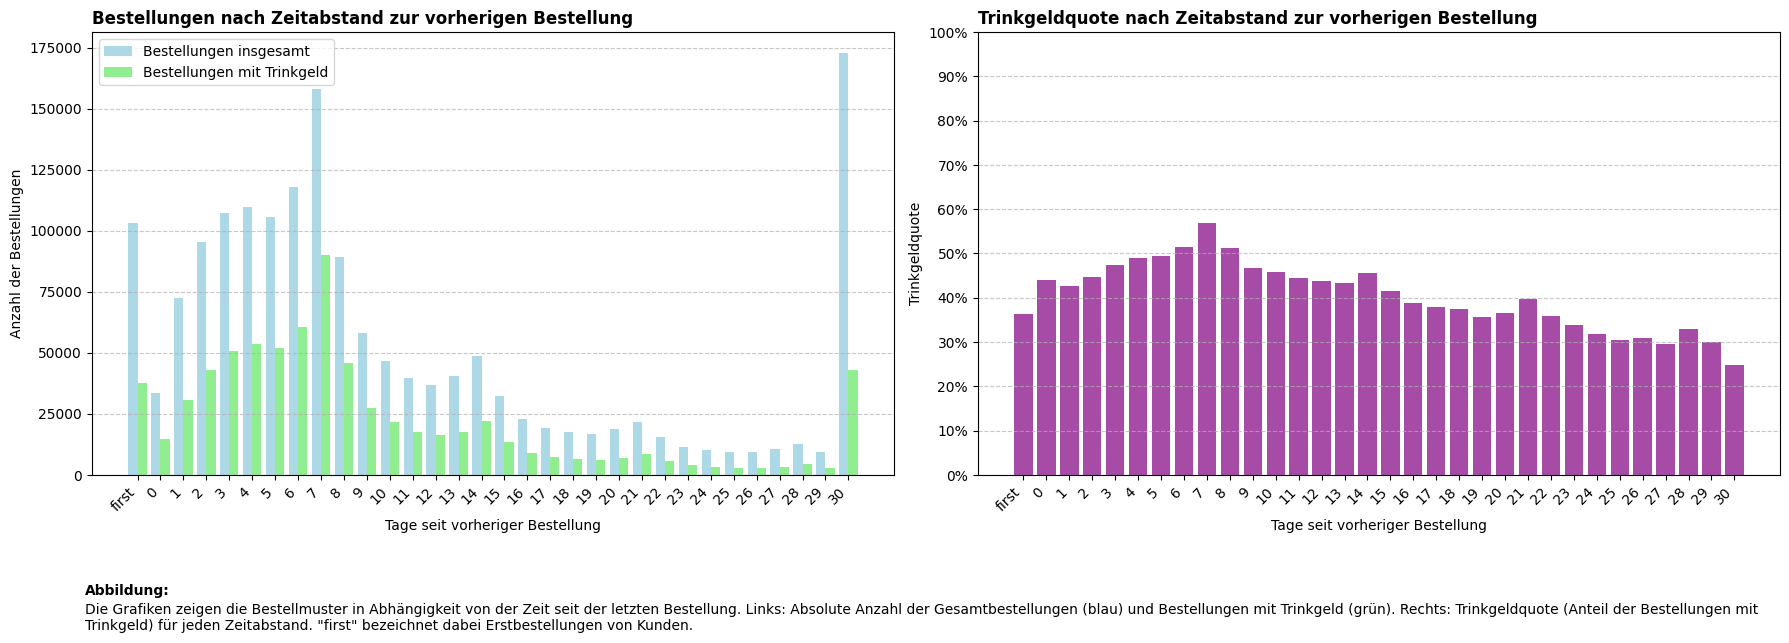

In [69]:
# plot code
days_since_prior = [
    "first" if row.days_since_prior_order is None else str(int(row.days_since_prior_order))
    for row in result
]
total_orders = [row.total_orders for row in result]
total_tips = [row.total_tips if row.total_tips else 0 for row in result]
tip_ratios = [row.total_tips / row.total_orders if row.total_orders > 0 else 0 for row in result]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
width = 0.4
x = range(len(days_since_prior))

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
bars1 = ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', 
                color='lightblue')
bars2 = ax1.bar([i + width for i in x], total_tips, width, 
                label='Bestellungen mit Trinkgeld', color='lightgreen')

# Formatierung Diagramm 1
ax1.set_xlabel('Tage seit vorheriger Bestellung')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen nach Zeitabstand zur vorherigen Bestellung', 
              loc='left', weight='bold')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(days_since_prior, rotation=45, ha='right')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Diagramm 2: Trinkgeldquote
bars3 = ax2.bar(range(len(days_since_prior)), tip_ratios, 
                color='purple', alpha=0.7)

# Formatierung Diagramm 2
ax2.set_xlabel('Tage seit vorheriger Bestellung')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Trinkgeldquote nach Zeitabstand zur vorherigen Bestellung', 
              loc='left', weight='bold')
ax2.set_ylim(0, 1)
ax2.set_yticks([i / 10 for i in range(0, 11)])
ax2.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax2.set_xticks(range(len(days_since_prior)))
ax2.set_xticklabels(days_since_prior, rotation=45, ha='right')
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Bildunterschrift
description = ('Die Grafiken zeigen die Bestellmuster in Abhängigkeit von der Zeit seit der letzten Bestellung. '
              'Links: Absolute Anzahl der Gesamtbestellungen (blau) und Bestellungen mit Trinkgeld (grün). '
              'Rechts: Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) für jeden Zeitabstand. '
              '"first" bezeichnet dabei Erstbestellungen von Kunden.')

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

In [70]:
data = {
    "days_since_prior_order": [
        "first" if row.days_since_prior_order is None else int(row.days_since_prior_order)
        for row in result_test
    ],
    "tip_status": [
        "with_tip" if row.tips else "without_tip" for row in result_test
    ],
}

df = pd.DataFrame(data)

# Kreuztabelle erstellen
crosstab = pd.crosstab(
    index=df["days_since_prior_order"],  # Zeilen: Tage seit vorheriger Bestellung
    columns=df["tip_status"],            # Spalten: Mit oder ohne Trinkgeld
).fillna(0)

In [71]:
chi2, p, dof, expected = chi2_contingency(crosstab)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = crosstab.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
camparsion_data_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(comparison_data_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
test_results_markdown = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(test_results_markdown))


Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                       6003 |                  4898.2  |                    5221 |               6325.8  |
|           1 |                       3244 |                  2710.51 |                    2967 |               3500.49 |
|           2 |                       1931 |                  1646.55 |                    1842 |               2126.45 |
|           3 |                       1397 |                  1205.35 |                    1365 |               1556.65 |
|           4 |                       1406 |                  1199.24 |                    1342 |               1548.76 |
|           5 |                       2005 |                  2079.03 |                    2759 |               2684.97 |
|           6 |                       6462 |                  6547.81 |                    8542 |               8456.19 |
|           7 |                      19897 |                 19699.7  |                   25244 |              25441.3  |
|           8 |                      39013 |                 38191    |                   48500 |              49322    |
|           9 |                      56300 |                 54945    |                   69604 |              70959    |
|          10 |                      61461 |                 61708    |                   79940 |              79693    |
|          11 |                      58575 |                 60887.1  |                   80945 |              78632.9  |
|          12 |                      55220 |                 58308.8  |                   78392 |              75303.2  |
|          13 |                      56133 |                 59601.9  |                   80442 |              76973.1  |
|          14 |                      57426 |                 60579.9  |                   81390 |              78236.1  |
|          15 |                      56499 |                 60345.5  |                   81780 |              77933.5  |
|          16 |                      54224 |                 58231.1  |                   79210 |              75202.9  |
|          17 |                      44257 |                 48367.5  |                   66575 |              62464.5  |
|          18 |                      35118 |                 38606    |                   53346 |              49858    |
|          19 |                      36331 |                 29631.4  |                   31568 |              38267.6  |
|          20 |                      27821 |                 22237    |                   23134 |              28718    |
|          21 |                      21782 |                 16750.1  |                   16600 |              21631.9  |
|          22 |                      16934 |                 13177.2  |                   13261 |              17017.8  |
|          23 |                      10674 |                  8559.19 |                    8939 |              11053.8  |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 53883.206 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 31        |
| Signifikanz           | Ja        |

In [72]:
# Daten aus der Order-Tabelle extrahieren (inkl. Stunde des Tages)
result = session.query(
    Order.hour_of_day,
    Order.day_of_the_week,
    Order.days_since_prior_order,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

In [73]:
result = session.query(
    Order.day_of_the_week,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

df = pd.DataFrame(result, columns=['day_of_week', 'tips_given'])

In [74]:
# logistische Regression
# One-Hot-Encoding für 'day_of_week' (von numerischen Werten zu binären Spalten)
df_encoded = pd.get_dummies(df, columns=['day_of_week'], prefix='day')

# Feature und Zielvariable
X = df_encoded.drop('tips_given', axis=1)  
y = df_encoded['tips_given']               

X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model_day = LogisticRegression(max_iter=1000)  # max_iter erhöhen, wenn Konvergenzprobleme auftreten

model_day.fit(X_train_day, y_train_day)

y_pred = model_day.predict(X_test_day)

accuracy = accuracy_score(y_test_day, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

coefficients = model_day.coef_.flatten()
intercept = model_day.intercept_[0]

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
coeff_df = pd.DataFrame({
    'Day of Week': days_of_week,
    'Coefficient': coefficients
})

print("Intercept:", intercept)
display(coeff_df)

Accuracy: 58.62%
Intercept: -0.25889614670551675


,Day of Week,Coefficient
0,Monday,0.366213
1,Tuesday,0.408174
2,Wednesday,-0.217128
3,Thursday,-0.232649
4,Friday,-0.194186
5,Saturday,-0.176958
6,Sunday,-0.212348


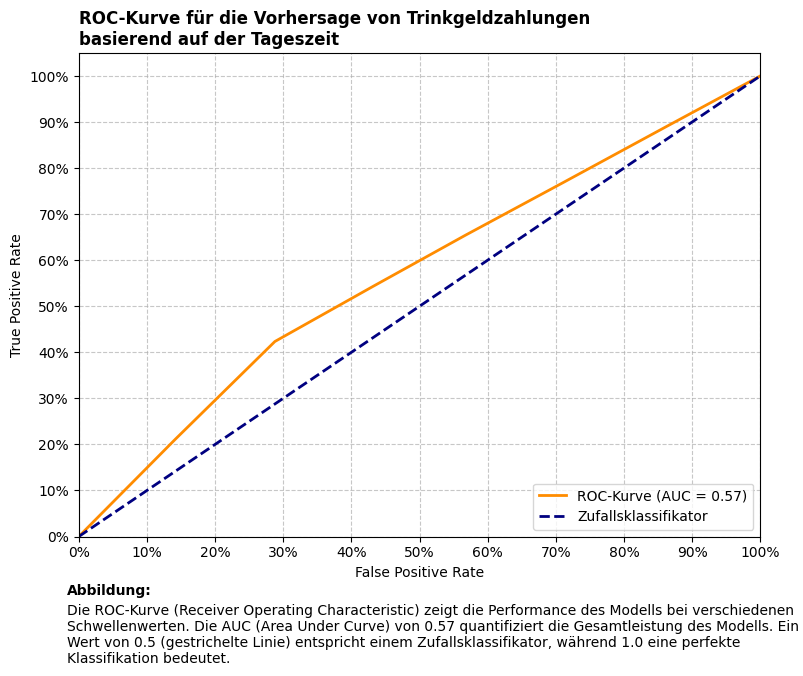

In [75]:

y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_test_day, y_prob_day)

# Berechnung der AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot der ROC-Kurve
fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(left=0.08)

# ROC-Kurve zeichnen
ax.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC-Kurve (AUC = {roc_auc:.2f})')

# Diagonale Linie (Zufallsklassifikator)
ax.plot([0, 1], [0, 1], color='navy', lw=2, 
        linestyle='--', label='Zufallsklassifikator')

# Achsen formatieren
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC-Kurve für die Vorhersage von Trinkgeldzahlungen\nbasierend auf der Tageszeit', 
             loc='left', weight='bold')

# Grid hinzufügen
ax.grid(True, linestyle='--', alpha=0.7)

# Legende
ax.legend(loc='lower right')

# Achsenbeschriftungen in Prozent
ax.set_xticks([i/10 for i in range(0, 11)])
ax.set_yticks([i/10 for i in range(0, 11)])
ax.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
ax.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurve (Receiver Operating Characteristic) zeigt die Performance des Modells bei verschiedenen '
               'Schwellenwerten. Die AUC (Area Under Curve) von {:.2f} quantifiziert die Gesamtleistung des Modells. '
               'Ein Wert von 0.5 (gestrichelte Linie) entspricht einem Zufallsklassifikator, '
               'während 1.0 eine perfekte Klassifikation bedeutet.'.format(roc_auc))

fig.text(0.09, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.09, -0.11, description, wrap=True)

plt.tight_layout()
plt.show()

In [76]:
# Query:
result = session.query(
    Order.hour_of_day,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

In [77]:
# Erstelle DataFrame
df = pd.DataFrame(result, columns=['hour_of_day', 'tips_given'])

# Umwandlung in kategoriale Variablen
df['hour_of_day'] = df['hour_of_day'].astype('category')

X = df[['hour_of_day']]  
y = df['tips_given']  

# Preprocessing mit OneHotEncoder für day_of_week und hour_of_day
preprocessor = ColumnTransformer(
    transformers=[
        ('hour_of_day', OneHotEncoder(), ['hour_of_day'])
    ]
)

# Aufteilen der Daten in Trainings- und Testdatensatz
X_train_hour, X_test_hour, y_train_hour, y_test_hour = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipeline erstellen
model_hour = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Vorverarbeitung
    ('classifier', LogisticRegression())  # Klassifikator
])

# Modell trainieren
model_hour.fit(X_train_hour, y_train_hour)

# Vorhersagen auf den Testdaten
y_pred_hour = model_hour.predict(X_test_hour)

# Genauigkeit des Modells
accuracy = accuracy_score(y_test_hour, y_pred_hour)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Zugriff auf Intercept und Koeffizienten
intercept = model_hour.named_steps['classifier'].intercept_[0]  # Der Intercept
coefficients = model_hour.named_steps['classifier'].coef_.flatten()  # Die Koeffizienten

# Wenn OneHotEncoder verwendet wird, benötigen wir die Feature-Namen, um sie den Koeffizienten zuzuordnen
# Dies ist besonders wichtig, da OneHotEncoding für die "day_of_week" und "hour_of_day"-Spalten zusätzliche Spalten erzeugt
# Holen der Spaltennamen des OneHotEncoders
ohe_feature_names = (
    model_hour.named_steps['preprocessor'].get_feature_names_out(input_features=['hour_of_day']).tolist()
)

# Erstelle DataFrame mit den Koeffizienten und den entsprechenden Feature-Namen
coeff_df = pd.DataFrame({
    'Feature': ohe_feature_names,
    'Coefficient': coefficients
})

# Ausgabe des Intercepts und der Koeffizienten
print("Intercept:", intercept)
display(coeff_df)

Accuracy: 57.65%
Intercept: -0.12848531701987678


,Feature,Coefficient
0,hour_of_day__hour_of_day_0,0.319291
1,hour_of_day__hour_of_day_1,0.221361
2,hour_of_day__hour_of_day_2,0.148062
3,hour_of_day__hour_of_day_3,0.103731
4,hour_of_day__hour_of_day_4,0.098312
5,hour_of_day__hour_of_day_5,-0.166472
6,hour_of_day__hour_of_day_6,-0.150764
7,hour_of_day__hour_of_day_7,-0.117070
8,hour_of_day__hour_of_day_8,-0.081748
9,hour_of_day__hour_of_day_9,-0.079419


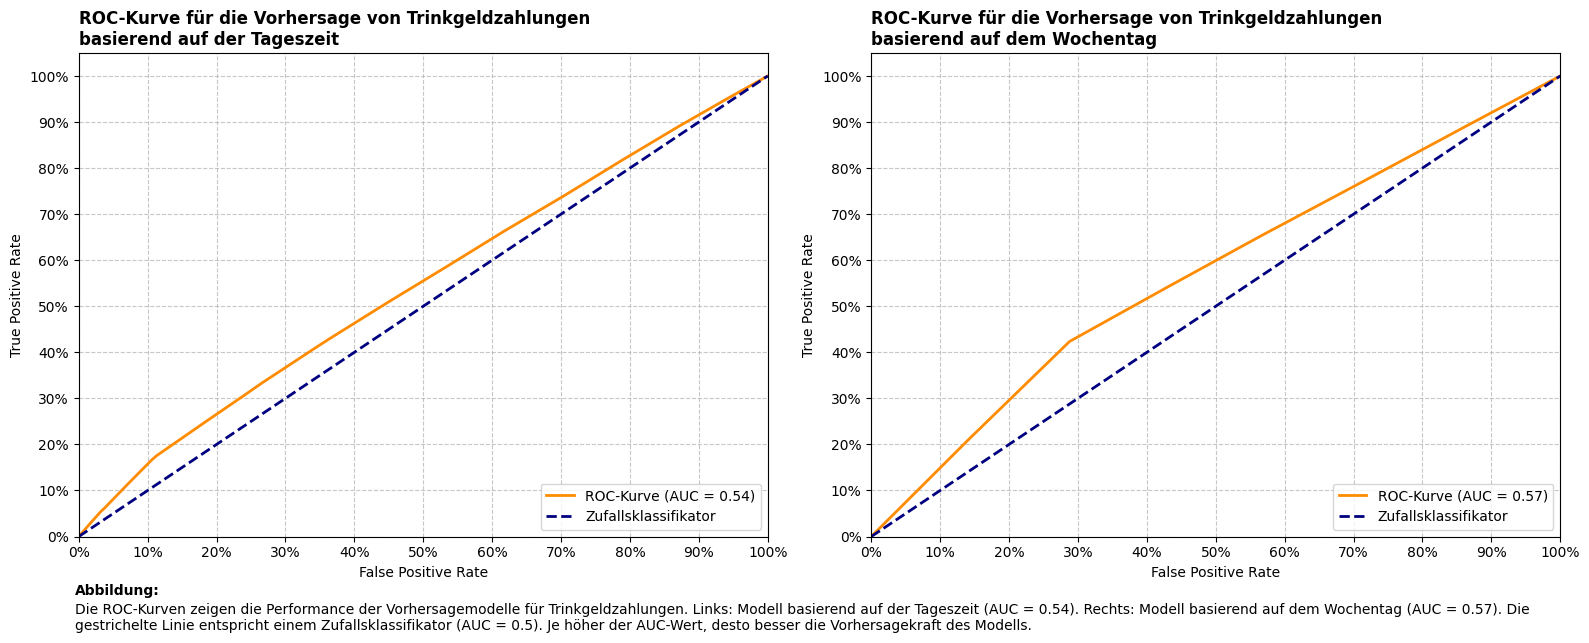

In [78]:

y_prob_hour = model_hour.predict_proba(X_test_hour)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Stunde des Tages
fpr_hour, tpr_hour, _ = roc_curve(y_test_hour, y_prob_hour)
roc_auc_hour = auc(fpr_hour, tpr_hour)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_day, tpr_day, _ = roc_curve(y_test_day, y_prob_day)
roc_auc_day = auc(fpr_day, tpr_day)

# Erstelle Subplots für die beiden ROC-Kurven
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(left=0.08)

# Plot 1: ROC-Kurve für Stunde des Tages
ax1.plot(fpr_hour, tpr_hour, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_hour:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung Plot 1
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-Kurve für die Vorhersage von Trinkgeldzahlungen\nbasierend auf der Tageszeit', 
              loc='left', weight='bold')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='lower right')

# Achsenbeschriftungen in Prozent für Plot 1
ax1.set_xticks([i/10 for i in range(0, 11)])
ax1.set_yticks([i/10 for i in range(0, 11)])
ax1.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
ax1.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Plot 2: ROC-Kurve für Wochentag
ax2.plot(fpr_day, tpr_day, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_day:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung Plot 2
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-Kurve für die Vorhersage von Trinkgeldzahlungen\nbasierend auf dem Wochentag', 
              loc='left', weight='bold')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='lower right')

# Achsenbeschriftungen in Prozent für Plot 2
ax2.set_xticks([i/10 for i in range(0, 11)])
ax2.set_yticks([i/10 for i in range(0, 11)])
ax2.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
ax2.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurven zeigen die Performance der Vorhersagemodelle für Trinkgeldzahlungen. '
               'Links: Modell basierend auf der Tageszeit (AUC = {:.2f}). '
               'Rechts: Modell basierend auf dem Wochentag (AUC = {:.2f}). '
               'Die gestrichelte Linie entspricht einem Zufallsklassifikator (AUC = 0.5). '
               'Je höher der AUC-Wert, desto besser die Vorhersagekraft des Modells.'.format(
                   roc_auc_hour, roc_auc_day))

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

plt.tight_layout()
plt.show()

In [79]:
result = session.query(
    Order.days_since_prior_order,
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  
).group_by(Order.days_since_prior_order).all()

result_test = session.query(
    Order.days_since_prior_order,
    Order.tips  # Hole die Trinkgelder direkt, ohne Aggregation
).all()

In [80]:
result = session.query(
    Order.hour_of_day,
    Order.day_of_the_week,
    Order.days_since_prior_order,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

In [81]:
# Erstelle DataFrame
df = pd.DataFrame(result, columns=['hour_of_day', 'day_of_the_week', 'days_since_prior_order', 'tips_given'])

# Umwandlung in kategoriale Variablen
df['hour_of_day'] = df['hour_of_day'].astype('category')
df['day_of_the_week'] = df['day_of_the_week'].astype('category')
df['days_since_prior_order'] = df['days_since_prior_order'].astype('category')

X = df[['hour_of_day', 'day_of_the_week', 'days_since_prior_order']]  
y = df['tips_given']  

# Preprocessing mit OneHotEncoder für day_of_week und hour_of_day
preprocessor = ColumnTransformer(
    transformers=[
        ('hour_of_day', OneHotEncoder(), ['hour_of_day', 'day_of_the_week', 'days_since_prior_order'])
    ]
)

# Aufteilen der Daten in Trainings- und Testdatensatz
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipeline erstellen
model_all = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Vorverarbeitung
    ('classifier', LogisticRegression())  # Klassifikator
])

# Modell trainieren
model_all.fit(X_train_all, y_train_all)

# Vorhersagen auf den Testdaten
y_pred_all = model_all.predict(X_test_all)

# Genauigkeit des Modells
accuracy = accuracy_score(y_test_all, y_pred_all)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Zugriff auf Intercept und Koeffizienten
intercept = model_all.named_steps['classifier'].intercept_[0]  # Der Intercept
coefficients = model_all.named_steps['classifier'].coef_.flatten()  # Die Koeffizienten

# Wenn OneHotEncoder verwendet wird, benötigen wir die Feature-Namen, um sie den Koeffizienten zuzuordnen
# Dies ist besonders wichtig, da OneHotEncoding für die "day_of_week" und "hour_of_day"-Spalten zusätzliche Spalten erzeugt
# Holen der Spaltennamen des OneHotEncoders
ohe_feature_names = (
    model_all.named_steps['preprocessor'].get_feature_names_out(input_features=['hour_of_day', 'day_of_the_week', 'days_since_prior_order']).tolist()
)

# Erstelle DataFrame mit den Koeffizienten und den entsprechenden Feature-Namen
coeff_df = pd.DataFrame({
    'Feature': ohe_feature_names,
    'Coefficient': coefficients
})

# Ausgabe des Intercepts und der Koeffizienten
print("Intercept:", intercept)
display(coeff_df)

Accuracy: 61.46%
Intercept: -0.2577138480810662


,Feature,Coefficient
0,hour_of_day__hour_of_day_0,0.328639
1,hour_of_day__hour_of_day_1,0.231733
2,hour_of_day__hour_of_day_2,0.151920
3,hour_of_day__hour_of_day_3,0.107983
4,hour_of_day__hour_of_day_4,0.114304
...,...,...
58,hour_of_day__days_since_prior_order_27.0,-0.479697
59,hour_of_day__days_since_prior_order_28.0,-0.369656
60,hour_of_day__days_since_prior_order_29.0,-0.486733
61,hour_of_day__days_since_prior_order_30.0,-0.726265


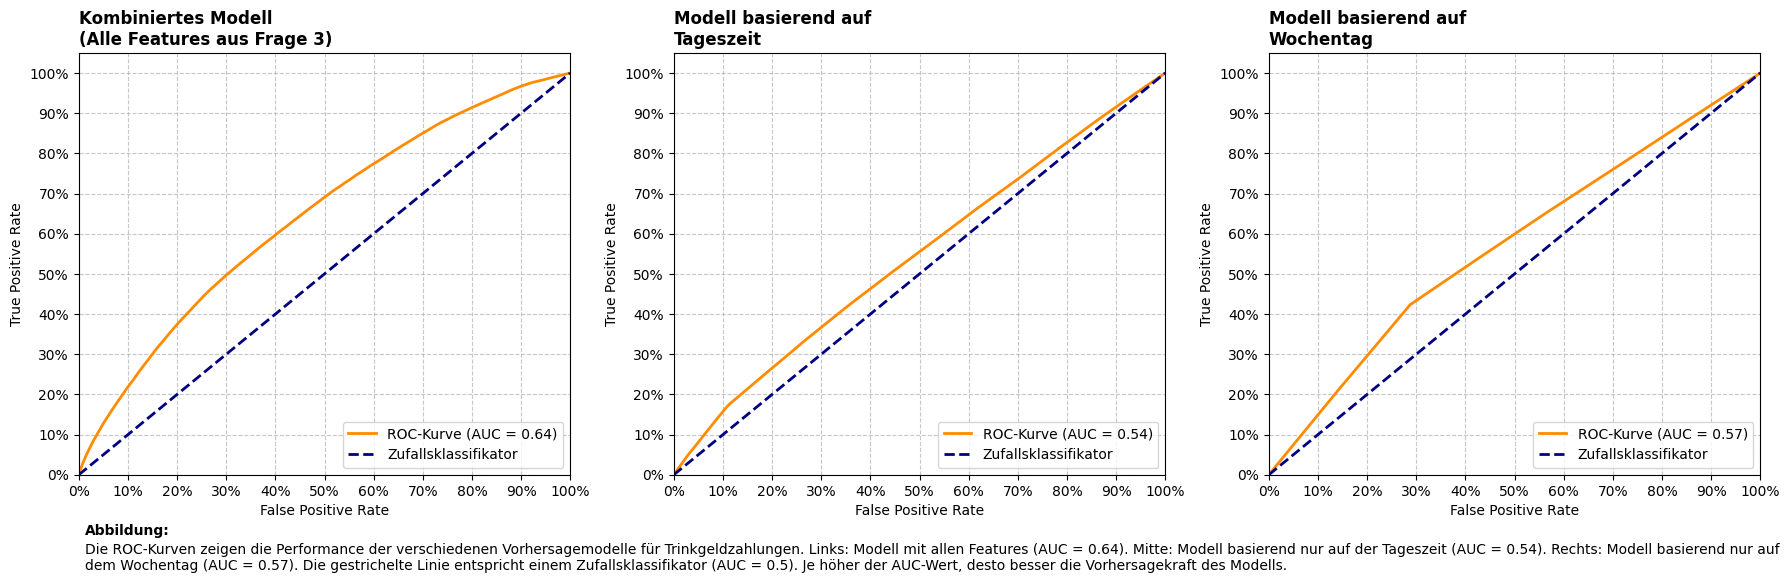

In [82]:

y_prob_hour = model_hour.predict_proba(X_test_hour)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Stunde des Tages
fpr_hour, tpr_hour, _ = roc_curve(y_test_hour, y_prob_hour)
roc_auc_hour = auc(fpr_hour, tpr_hour)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_day, tpr_day, _ = roc_curve(y_test_day, y_prob_day)
roc_auc_day = auc(fpr_day, tpr_day)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_all = model_all.predict_proba(X_test_all)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_all, tpr_all, _ = roc_curve(y_test_all, y_prob_all)
roc_auc_all = auc(fpr_all, tpr_all)
# Erstelle Subplots für die beiden ROC-Kurven
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Plot 1: ROC-Kurve für alle Features
ax1.plot(fpr_all, tpr_all, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_all:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 2: ROC-Kurve für Stunde des Tages
ax2.plot(fpr_hour, tpr_hour, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_hour:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 3: ROC-Kurve für Wochentag
ax3.plot(fpr_day, tpr_day, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_day:.2f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung für alle Subplots
for ax, title in zip([ax1, ax2, ax3], 
                    ['Kombiniertes Modell\n(Alle Features aus Frage 3)',
                     'Modell basierend auf\nTageszeit',
                     'Modell basierend auf\nWochentag']):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title, loc='left', weight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='lower right')
    
    # Prozentuale Achsenbeschriftungen
    ax.set_xticks([i/10 for i in range(0, 11)])
    ax.set_yticks([i/10 for i in range(0, 11)])
    ax.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
    ax.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurven zeigen die Performance der verschiedenen Vorhersagemodelle für Trinkgeldzahlungen. '
               'Links: Modell mit allen Features (AUC = {:.2f}). '
               'Mitte: Modell basierend nur auf der Tageszeit (AUC = {:.2f}). '
               'Rechts: Modell basierend nur auf dem Wochentag (AUC = {:.2f}). '
               'Die gestrichelte Linie entspricht einem Zufallsklassifikator (AUC = 0.5). '
               'Je höher der AUC-Wert, desto besser die Vorhersagekraft des Modells.'.format(
                   roc_auc_all, roc_auc_hour, roc_auc_day))

fig.text(0.05, 0.1, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, 0.045, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

---
# <h2 id="handlungsempfehlungen">Handlungsempfehlungen</h2>



### Abteilung Disposition

In [83]:
def get_enhanced_features(session):  
    query = session.query(
        Order.order_id,
        Order.hour_of_day,
        Order.day_of_the_week,
        Order.days_since_prior_order,
        Order.tips.label('tips_given'),
        Order.user_id,
        # Alkohol-Produkte in Bestellung
        func.max(case((Department.department_name == 'alcohol', 1), else_=0)).label('has_alcohol'),
        # Tiefkühl-Produkte in Bestellung
        func.max(case((Department.department_name == 'frozen', 1), else_=0)).label('has_frozen'),
        # Organische Produkte
        func.sum(case((Product.product_name.like('%organic%'), 1), else_=0)).label('organic_count'),
        func.count(Product.product_id).label('total_products')
    ).select_from(Order).join(Einkaufskorb).join(Product).join(Department).group_by(
        Order.order_id,
        Order.hour_of_day,
        Order.day_of_the_week,
        Order.days_since_prior_order,
        Order.tips,
        Order.user_id
    )

    # Daten in DataFrame laden
    df = pd.read_sql(query.statement, session.bind)
    
    # Berechne organic_ratio
    df['organic_ratio'] = df['organic_count'] / df['total_products']
    
    # Berechne user_tip_ratio
    user_tips = df.groupby('user_id')['tips_given'].mean().reset_index()
    user_tips.columns = ['user_id', 'user_tip_ratio']
    
    # Merge mit Hauptdaten
    df = df.merge(user_tips, on='user_id', how='left')
    
    # Berechne user_order_count
    user_orders = df.groupby('user_id').size().reset_index()
    user_orders.columns = ['user_id', 'user_order_count']
    df = df.merge(user_orders, on='user_id', how='left')
    
    # Überprüfe die verfügbaren Spalten
    # print("Available columns:", df.columns.tolist())
    
    return df

def train_enhanced_model(df):
    # Umwandlung in kategoriale Variablen
    df['hour_of_day'] = df['hour_of_day'].astype('category')
    df['day_of_the_week'] = df['day_of_the_week'].astype('category')
    df['days_since_prior_order'] = df['days_since_prior_order'].astype('category')
    
    # Definiere Features
    categorical_features = ['hour_of_day', 'day_of_the_week', 'days_since_prior_order']
    numerical_features = ['has_alcohol', 'has_frozen', 'organic_ratio', 
                         'user_order_count', 'user_tip_ratio']
    
    X = df[categorical_features + numerical_features]
    y = df['tips_given']
    
    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', 'passthrough', numerical_features)
        ]
    )
    
    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Pipeline erstellen
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    
    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersagen auf den Testdaten
    y_pred = model.predict(X_test)
    
    # Genauigkeit des Modells
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Zugriff auf Intercept und Koeffizienten
    intercept = model.named_steps['classifier'].intercept_[0]
    coefficients = model.named_steps['classifier'].coef_.flatten()
    
    # Feature-Namen generieren
    cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([cat_feature_names, numerical_features])
    
    # Erstelle DataFrame mit den Koeffizienten
    coeff_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Coefficient': coefficients
    })
    
    # Ausgabe des Intercepts und der Koeffizienten
    print("\nIntercept:", intercept)
    display(coeff_df)
    
    return model, accuracy, X_train, X_test, y_train, y_test

# Hauptausführung
try:
    # Daten holen
    enhanced_data = get_enhanced_features(session)
    print("\nShape of data:", enhanced_data.shape)
    
    # Model trainieren
    model, accuracy, X_train, X_test, y_train, y_test = train_enhanced_model(enhanced_data)
    
except Exception as e:
    print(f"Error occurred: {str(e)}")


Shape of data: (1673021, 13)
Accuracy: 80.15%

Intercept: -2.271823117154158


,Feature,Coefficient
0,hour_of_day_0,0.406899
1,hour_of_day_1,0.436991
2,hour_of_day_2,0.314170
3,hour_of_day_3,0.311803
4,hour_of_day_4,0.327951
...,...,...
63,has_alcohol,1.184161
64,has_frozen,-0.459821
65,organic_ratio,0.106204
66,user_order_count,0.001337


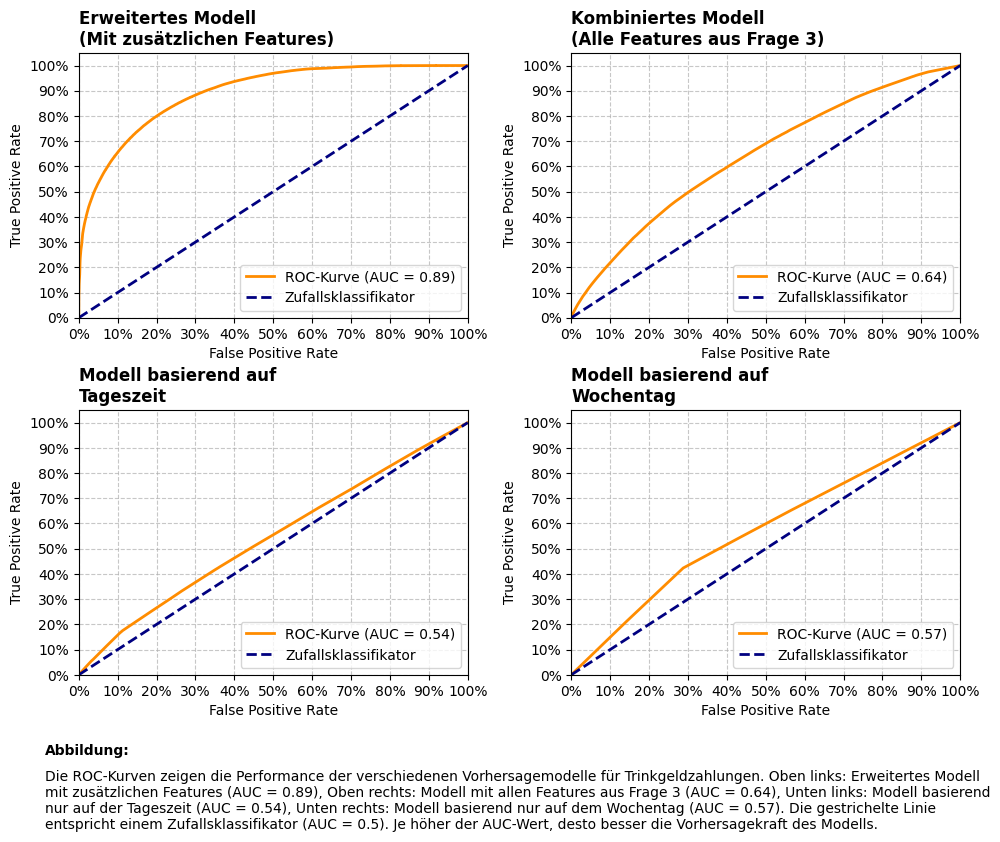

In [84]:
y_prob_enhanced = model.predict_proba(X_test)[:, 1]

# Berechnung der ROC-Kurve für das erweiterte Modell
fpr_enhanced, tpr_enhanced, _ = roc_curve(y_test, y_prob_enhanced)
roc_auc_enhanced = auc(fpr_enhanced, tpr_enhanced)

# Erstelle 2x2 Subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(left=0.08)

# Plot 1 (oben links): ROC-Kurve für erweitertes Modell
ax1.plot(fpr_enhanced, tpr_enhanced, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_enhanced:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 2 (oben rechts): ROC-Kurve für alle bisherigen Features
ax2.plot(fpr_all, tpr_all, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_all:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 3 (unten links): ROC-Kurve für Stunde des Tages
ax3.plot(fpr_hour, tpr_hour, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_hour:.2f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 4 (unten rechts): ROC-Kurve für Wochentag
ax4.plot(fpr_day, tpr_day, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_day:.2f})')
ax4.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung für alle Subplots
for ax, title in zip([ax1, ax2, ax3, ax4], 
                    ['Erweitertes Modell\n(Mit zusätzlichen Features)',
                     'Kombiniertes Modell\n(Alle Features aus Frage 3)',
                     'Modell basierend auf\nTageszeit',
                     'Modell basierend auf\nWochentag']):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title, loc='left', weight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='lower right')
    
    # Prozentuale Achsenbeschriftungen
    ax.set_xticks([i/10 for i in range(0, 11)])
    ax.set_yticks([i/10 for i in range(0, 11)])
    ax.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
    ax.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurven zeigen die Performance der verschiedenen Vorhersagemodelle für Trinkgeldzahlungen. '
               'Oben links: Erweitertes Modell mit zusätzlichen Features (AUC = {:.2f}), '
               'Oben rechts: Modell mit allen Features aus Frage 3 (AUC = {:.2f}), '
               'Unten links: Modell basierend nur auf der Tageszeit (AUC = {:.2f}), '
               'Unten rechts: Modell basierend nur auf dem Wochentag (AUC = {:.2f}). '
               'Die gestrichelte Linie entspricht einem Zufallsklassifikator (AUC = 0.5). '
               'Je höher der AUC-Wert, desto besser die Vorhersagekraft des Modells.'.format(
                   roc_auc_enhanced, roc_auc_all, roc_auc_hour, roc_auc_day))

fig.text(0.05, 0.05, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.04, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.15)

plt.show()